In [1]:
import os
import time
import random
import glob
import random
import scipy.ndimage
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.applications.densenet import DenseNet121
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
SOURCE_DIR = os.path.abspath('/data/aumkar/train')
TARGET_DIR = os.path.abspath('/data/aumkar/validation')
DATA_LOAD_DIR = os.path.abspath('/data/aumkar/data_load')

In [4]:
source_path = list(paths.list_images(SOURCE_DIR))
target_path = list(paths.list_images(TARGET_DIR))

In [5]:
random.shuffle(source_path)

In [6]:
random.shuffle(target_path)

In [7]:
(len(source_path), len(target_path))

(152397, 55388)

In [8]:
labels_source = [p.split(os.path.sep)[-2] for p in source_path]
labels_target = [p.split(os.path.sep)[-2] for p in target_path]

In [9]:
le = LabelEncoder()
labels = le.fit_transform(labels_source)
labels_t = le.fit_transform(labels_target)

In [10]:
labels_t.shape

(55388,)

In [11]:
labels_unique = np.load(os.path.join(DATA_LOAD_DIR, 'labels.npy'))

In [12]:
weights = {0 : 0.51, 1 : 1., 2 : 0.44, 3 : 0.57, 4 : 0.77, 5 : 0.51, 6 : 0.42, 7 : 0.6, 8 : 0.68, 9 : 0.63, 10 : 0.46, 11 : 0.76}

In [13]:
clf = linear_model.SGDClassifier(max_iter = 4000, tol = 1e-4, n_jobs = -1, class_weight = weights, warm_start = True)

In [14]:
def model_create(transfer_model):
    if transfer_model == 'InceptionV3':
        with tf.device('/gpu:1'):
            return InceptionV3(weights = 'imagenet', include_top = False)
    elif transfer_model == 'VGG16':
        with tf.device('/gpu:1'):
            return VGG16(weights = 'imagenet', include_top = False)
    elif transfer_model == 'VGG19':
        with tf.device('/gpu:1'):
            return VGG19(weights = 'imagenet', include_top = False)
    elif transfer_model == 'Xception':
        with tf.device('/gpu:1'):
            return Xception(weights = 'imagenet', include_top = False)
    elif transfer_model == 'DenseNet121':
        with tf.device('/gpu:1'):
            return DenseNet121(weights = 'imagenet', include_top = False)

In [15]:
def model_reshape(transfer_model, features):
    if transfer_model == 'InceptionV3':
        return features.reshape((features.shape[0], 5 * 5 * 2048))
    elif transfer_model == 'VGG16':
        return features.reshape((features.shape[0], 7 * 7 * 512))
    elif transfer_model == 'VGG19':
        return features.reshape((features.shape[0], 7 * 7 * 512))
    elif transfer_model == 'Xception':
        return features.reshape((features.shape[0], 7 * 7 * 2048))
    elif transfer_model == 'DenseNet121':
        return features.reshape((features.shape[0], 7 * 7 * 1024))

In [16]:
def model_train(i, model, features, label):
    
    print('Training batch: ', i + 1)
    model.partial_fit(features, label, classes = labels_unique)
       
    return model

In [17]:
def feature_extract(tpath, spath, batch_size, pseudo_labels, source_labels, model_, source, trained_model, iteration, n_k):
    
    pred = []
    s_path = []
    model1 = model_create(model_)
    
    if source == 'target' and iteration != 0:
        
        idx = np.arange(len(tpath))
        np.random.shuffle(idx)
        
        sampled_idxs = idx[:int(n_k)]
        
        target_sample = np.asarray(tpath)[sampled_idxs]
        labels_sample = pseudo_labels[sampled_idxs]
        
        slabels = source_labels.tolist()
        
        spath = spath + target_sample.tolist()
        slabels = slabels + labels_sample.tolist()
        
        assert(len(spath) == len(slabels))
        
    for (b, i) in enumerate(range(0, len(spath), batch_size)):
        
        print("Processing batch {}/{}".format(b + 1, int(np.ceil(len(spath) / float(batch_size)))))
        
        batchPaths = spath[i: i + batch_size]
        if source == 'target' and iteration != 0:
            batchLabels = np.asarray(slabels)[i: i + batch_size]
        else:
            batchLabels = source_labels[i: i + batch_size]
        batchImages = []
        
        for imagePath in batchPaths:
            
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)

            image = np.expand_dims(image, axis=0)
            image = imagenet_utils.preprocess_input(image)

            batchImages.append(image)

        batchImages = np.vstack(batchImages)
            
        features = model1.predict(batchImages, batch_size = batch_size)
        features1 = model_reshape(model_, features)
        
        if source == 'source' and b == 0 and iteration == 0:
            model_partial = model_train(b, clf, features1, batchLabels)
        elif source == 'source' and b != 0 and iteration == 0:
            model_partial = model_train(b, model_partial, features1, batchLabels)
        elif source == 'target' and iteration == 0:
            pred.append(target_pred(trained_model, features1))
        elif source == 'target' and b == 0 and iteration != 0:
            model_partial = model_train(b, clf, features1, batchLabels)
        elif source == 'target' and b != 0 and iteration != 0:
            model_partial = model_train(b, model_partial, features1, batchLabels)

    del features, features1
    
    if source == 'target' and iteration != 0:
        return model_partial
    if source == 'source' and iteration == 0:
        return model_partial
    elif source == 'target' and iteration == 0:
        return np.hstack(np.asarray(pred))

In [18]:
def target_pred(model, target_features):
    
    print('Predicting batch features')
    return model.predict(target_features)

In [19]:
def sslda_online(M):
    
    score = []
    
    svm_model = feature_extract(None, source_path, 256, None, labels, 'DenseNet121', 'source', None, 0, None)
    
    target_predictions = feature_extract(None, target_path, 256, None, labels_t, 'DenseNet121', 'target', svm_model, 0, None)
    
    for i in range(1, M):
        
        print('Iteration: ', i)
         
        n = (i / float(M)) * len(target_path)
        
        if i == 1:
            mod = feature_extract(target_path, source_path, 256, target_predictions, labels, 'DenseNet121', 'target', None, i, n)
            fin_pred = feature_extract(None, target_path, 256, None, labels_t, 'DenseNet121', 'target', mod, 0, None)
        else:
            mod = feature_extract(target_path, source_path, 256, fin_pred, labels, 'DenseNet121', 'target', None, i, n)
            fin_pred = feature_extract(None, target_path, 256, None, labels_t, 'DenseNet121', 'target', mod, 0, None)
        
        score.append(accuracy_score(labels_t, fin_pred))
        
    del mod    
        
    return fin_pred, score

In [20]:
pred = []
mean_acc = []

starttime = time.time()
for i in range(3):
    
    print('ENSEMBLE ITERATION: ', i+1)
    
    sslda_pred, acc = sslda_online(10)
    
    pred.append(sslda_pred)
    mean_acc.append(acc)
    
    print('That took {} seconds'.format(time.time() - starttime))

('ENSEMBLE ITERATION: ', 1)
Processing batch 1/596
('Training batch: ', 1)
Processing batch 2/596
('Training batch: ', 2)
Processing batch 3/596
('Training batch: ', 3)
Processing batch 4/596
('Training batch: ', 4)
Processing batch 5/596
('Training batch: ', 5)
Processing batch 6/596
('Training batch: ', 6)
Processing batch 7/596
('Training batch: ', 7)
Processing batch 8/596
('Training batch: ', 8)
Processing batch 9/596
('Training batch: ', 9)
Processing batch 10/596
('Training batch: ', 10)
Processing batch 11/596
('Training batch: ', 11)
Processing batch 12/596
('Training batch: ', 12)
Processing batch 13/596
('Training batch: ', 13)
Processing batch 14/596
('Training batch: ', 14)
Processing batch 15/596
('Training batch: ', 15)
Processing batch 16/596
('Training batch: ', 16)
Processing batch 17/596
('Training batch: ', 17)
Processing batch 18/596
('Training batch: ', 18)
Processing batch 19/596
('Training batch: ', 19)
Processing batch 20/596
('Training batch: ', 20)
Processing

('Training batch: ', 165)
Processing batch 166/596
('Training batch: ', 166)
Processing batch 167/596
('Training batch: ', 167)
Processing batch 168/596
('Training batch: ', 168)
Processing batch 169/596
('Training batch: ', 169)
Processing batch 170/596
('Training batch: ', 170)
Processing batch 171/596
('Training batch: ', 171)
Processing batch 172/596
('Training batch: ', 172)
Processing batch 173/596
('Training batch: ', 173)
Processing batch 174/596
('Training batch: ', 174)
Processing batch 175/596
('Training batch: ', 175)
Processing batch 176/596
('Training batch: ', 176)
Processing batch 177/596
('Training batch: ', 177)
Processing batch 178/596
('Training batch: ', 178)
Processing batch 179/596
('Training batch: ', 179)
Processing batch 180/596
('Training batch: ', 180)
Processing batch 181/596
('Training batch: ', 181)
Processing batch 182/596
('Training batch: ', 182)
Processing batch 183/596
('Training batch: ', 183)
Processing batch 184/596
('Training batch: ', 184)
Proce

('Training batch: ', 326)
Processing batch 327/596
('Training batch: ', 327)
Processing batch 328/596
('Training batch: ', 328)
Processing batch 329/596
('Training batch: ', 329)
Processing batch 330/596
('Training batch: ', 330)
Processing batch 331/596
('Training batch: ', 331)
Processing batch 332/596
('Training batch: ', 332)
Processing batch 333/596
('Training batch: ', 333)
Processing batch 334/596
('Training batch: ', 334)
Processing batch 335/596
('Training batch: ', 335)
Processing batch 336/596
('Training batch: ', 336)
Processing batch 337/596
('Training batch: ', 337)
Processing batch 338/596
('Training batch: ', 338)
Processing batch 339/596
('Training batch: ', 339)
Processing batch 340/596
('Training batch: ', 340)
Processing batch 341/596
('Training batch: ', 341)
Processing batch 342/596
('Training batch: ', 342)
Processing batch 343/596
('Training batch: ', 343)
Processing batch 344/596
('Training batch: ', 344)
Processing batch 345/596
('Training batch: ', 345)
Proce

('Training batch: ', 487)
Processing batch 488/596
('Training batch: ', 488)
Processing batch 489/596
('Training batch: ', 489)
Processing batch 490/596
('Training batch: ', 490)
Processing batch 491/596
('Training batch: ', 491)
Processing batch 492/596
('Training batch: ', 492)
Processing batch 493/596
('Training batch: ', 493)
Processing batch 494/596
('Training batch: ', 494)
Processing batch 495/596
('Training batch: ', 495)
Processing batch 496/596
('Training batch: ', 496)
Processing batch 497/596
('Training batch: ', 497)
Processing batch 498/596
('Training batch: ', 498)
Processing batch 499/596
('Training batch: ', 499)
Processing batch 500/596
('Training batch: ', 500)
Processing batch 501/596
('Training batch: ', 501)
Processing batch 502/596
('Training batch: ', 502)
Processing batch 503/596
('Training batch: ', 503)
Processing batch 504/596
('Training batch: ', 504)
Processing batch 505/596
('Training batch: ', 505)
Processing batch 506/596
('Training batch: ', 506)
Proce

Predicting batch features
Processing batch 54/217
Predicting batch features
Processing batch 55/217
Predicting batch features
Processing batch 56/217
Predicting batch features
Processing batch 57/217
Predicting batch features
Processing batch 58/217
Predicting batch features
Processing batch 59/217
Predicting batch features
Processing batch 60/217
Predicting batch features
Processing batch 61/217
Predicting batch features
Processing batch 62/217
Predicting batch features
Processing batch 63/217
Predicting batch features
Processing batch 64/217
Predicting batch features
Processing batch 65/217
Predicting batch features
Processing batch 66/217
Predicting batch features
Processing batch 67/217
Predicting batch features
Processing batch 68/217
Predicting batch features
Processing batch 69/217
Predicting batch features
Processing batch 70/217
Predicting batch features
Processing batch 71/217
Predicting batch features
Processing batch 72/217
Predicting batch features
Processing batch 73/217


Predicting batch features
Processing batch 216/217
Predicting batch features
Processing batch 217/217
Predicting batch features
('Iteration: ', 1)
Processing batch 1/617
('Training batch: ', 1)
Processing batch 2/617
('Training batch: ', 2)
Processing batch 3/617
('Training batch: ', 3)
Processing batch 4/617
('Training batch: ', 4)
Processing batch 5/617
('Training batch: ', 5)
Processing batch 6/617
('Training batch: ', 6)
Processing batch 7/617
('Training batch: ', 7)
Processing batch 8/617
('Training batch: ', 8)
Processing batch 9/617
('Training batch: ', 9)
Processing batch 10/617
('Training batch: ', 10)
Processing batch 11/617
('Training batch: ', 11)
Processing batch 12/617
('Training batch: ', 12)
Processing batch 13/617
('Training batch: ', 13)
Processing batch 14/617
('Training batch: ', 14)
Processing batch 15/617
('Training batch: ', 15)
Processing batch 16/617
('Training batch: ', 16)
Processing batch 17/617
('Training batch: ', 17)
Processing batch 18/617
('Training bat

('Training batch: ', 163)
Processing batch 164/617
('Training batch: ', 164)
Processing batch 165/617
('Training batch: ', 165)
Processing batch 166/617
('Training batch: ', 166)
Processing batch 167/617
('Training batch: ', 167)
Processing batch 168/617
('Training batch: ', 168)
Processing batch 169/617
('Training batch: ', 169)
Processing batch 170/617
('Training batch: ', 170)
Processing batch 171/617
('Training batch: ', 171)
Processing batch 172/617
('Training batch: ', 172)
Processing batch 173/617
('Training batch: ', 173)
Processing batch 174/617
('Training batch: ', 174)
Processing batch 175/617
('Training batch: ', 175)
Processing batch 176/617
('Training batch: ', 176)
Processing batch 177/617
('Training batch: ', 177)
Processing batch 178/617
('Training batch: ', 178)
Processing batch 179/617
('Training batch: ', 179)
Processing batch 180/617
('Training batch: ', 180)
Processing batch 181/617
('Training batch: ', 181)
Processing batch 182/617
('Training batch: ', 182)
Proce

('Training batch: ', 324)
Processing batch 325/617
('Training batch: ', 325)
Processing batch 326/617
('Training batch: ', 326)
Processing batch 327/617
('Training batch: ', 327)
Processing batch 328/617
('Training batch: ', 328)
Processing batch 329/617
('Training batch: ', 329)
Processing batch 330/617
('Training batch: ', 330)
Processing batch 331/617
('Training batch: ', 331)
Processing batch 332/617
('Training batch: ', 332)
Processing batch 333/617
('Training batch: ', 333)
Processing batch 334/617
('Training batch: ', 334)
Processing batch 335/617
('Training batch: ', 335)
Processing batch 336/617
('Training batch: ', 336)
Processing batch 337/617
('Training batch: ', 337)
Processing batch 338/617
('Training batch: ', 338)
Processing batch 339/617
('Training batch: ', 339)
Processing batch 340/617
('Training batch: ', 340)
Processing batch 341/617
('Training batch: ', 341)
Processing batch 342/617
('Training batch: ', 342)
Processing batch 343/617
('Training batch: ', 343)
Proce

('Training batch: ', 485)
Processing batch 486/617
('Training batch: ', 486)
Processing batch 487/617
('Training batch: ', 487)
Processing batch 488/617
('Training batch: ', 488)
Processing batch 489/617
('Training batch: ', 489)
Processing batch 490/617
('Training batch: ', 490)
Processing batch 491/617
('Training batch: ', 491)
Processing batch 492/617
('Training batch: ', 492)
Processing batch 493/617
('Training batch: ', 493)
Processing batch 494/617
('Training batch: ', 494)
Processing batch 495/617
('Training batch: ', 495)
Processing batch 496/617
('Training batch: ', 496)
Processing batch 497/617
('Training batch: ', 497)
Processing batch 498/617
('Training batch: ', 498)
Processing batch 499/617
('Training batch: ', 499)
Processing batch 500/617
('Training batch: ', 500)
Processing batch 501/617
('Training batch: ', 501)
Processing batch 502/617
('Training batch: ', 502)
Processing batch 503/617
('Training batch: ', 503)
Processing batch 504/617
('Training batch: ', 504)
Proce

Predicting batch features
Processing batch 31/217
Predicting batch features
Processing batch 32/217
Predicting batch features
Processing batch 33/217
Predicting batch features
Processing batch 34/217
Predicting batch features
Processing batch 35/217
Predicting batch features
Processing batch 36/217
Predicting batch features
Processing batch 37/217
Predicting batch features
Processing batch 38/217
Predicting batch features
Processing batch 39/217
Predicting batch features
Processing batch 40/217
Predicting batch features
Processing batch 41/217
Predicting batch features
Processing batch 42/217
Predicting batch features
Processing batch 43/217
Predicting batch features
Processing batch 44/217
Predicting batch features
Processing batch 45/217
Predicting batch features
Processing batch 46/217
Predicting batch features
Processing batch 47/217
Predicting batch features
Processing batch 48/217
Predicting batch features
Processing batch 49/217
Predicting batch features
Processing batch 50/217


Predicting batch features
Processing batch 193/217
Predicting batch features
Processing batch 194/217
Predicting batch features
Processing batch 195/217
Predicting batch features
Processing batch 196/217
Predicting batch features
Processing batch 197/217
Predicting batch features
Processing batch 198/217
Predicting batch features
Processing batch 199/217
Predicting batch features
Processing batch 200/217
Predicting batch features
Processing batch 201/217
Predicting batch features
Processing batch 202/217
Predicting batch features
Processing batch 203/217
Predicting batch features
Processing batch 204/217
Predicting batch features
Processing batch 205/217
Predicting batch features
Processing batch 206/217
Predicting batch features
Processing batch 207/217
Predicting batch features
Processing batch 208/217
Predicting batch features
Processing batch 209/217
Predicting batch features
Processing batch 210/217
Predicting batch features
Processing batch 211/217
Predicting batch features
Proce

Processing batch 140/639
('Training batch: ', 140)
Processing batch 141/639
('Training batch: ', 141)
Processing batch 142/639
('Training batch: ', 142)
Processing batch 143/639
('Training batch: ', 143)
Processing batch 144/639
('Training batch: ', 144)
Processing batch 145/639
('Training batch: ', 145)
Processing batch 146/639
('Training batch: ', 146)
Processing batch 147/639
('Training batch: ', 147)
Processing batch 148/639
('Training batch: ', 148)
Processing batch 149/639
('Training batch: ', 149)
Processing batch 150/639
('Training batch: ', 150)
Processing batch 151/639
('Training batch: ', 151)
Processing batch 152/639
('Training batch: ', 152)
Processing batch 153/639
('Training batch: ', 153)
Processing batch 154/639
('Training batch: ', 154)
Processing batch 155/639
('Training batch: ', 155)
Processing batch 156/639
('Training batch: ', 156)
Processing batch 157/639
('Training batch: ', 157)
Processing batch 158/639
('Training batch: ', 158)
Processing batch 159/639
('Trai

Processing batch 301/639
('Training batch: ', 301)
Processing batch 302/639
('Training batch: ', 302)
Processing batch 303/639
('Training batch: ', 303)
Processing batch 304/639
('Training batch: ', 304)
Processing batch 305/639
('Training batch: ', 305)
Processing batch 306/639
('Training batch: ', 306)
Processing batch 307/639
('Training batch: ', 307)
Processing batch 308/639
('Training batch: ', 308)
Processing batch 309/639
('Training batch: ', 309)
Processing batch 310/639
('Training batch: ', 310)
Processing batch 311/639
('Training batch: ', 311)
Processing batch 312/639
('Training batch: ', 312)
Processing batch 313/639
('Training batch: ', 313)
Processing batch 314/639
('Training batch: ', 314)
Processing batch 315/639
('Training batch: ', 315)
Processing batch 316/639
('Training batch: ', 316)
Processing batch 317/639
('Training batch: ', 317)
Processing batch 318/639
('Training batch: ', 318)
Processing batch 319/639
('Training batch: ', 319)
Processing batch 320/639
('Trai

Processing batch 462/639
('Training batch: ', 462)
Processing batch 463/639
('Training batch: ', 463)
Processing batch 464/639
('Training batch: ', 464)
Processing batch 465/639
('Training batch: ', 465)
Processing batch 466/639
('Training batch: ', 466)
Processing batch 467/639
('Training batch: ', 467)
Processing batch 468/639
('Training batch: ', 468)
Processing batch 469/639
('Training batch: ', 469)
Processing batch 470/639
('Training batch: ', 470)
Processing batch 471/639
('Training batch: ', 471)
Processing batch 472/639
('Training batch: ', 472)
Processing batch 473/639
('Training batch: ', 473)
Processing batch 474/639
('Training batch: ', 474)
Processing batch 475/639
('Training batch: ', 475)
Processing batch 476/639
('Training batch: ', 476)
Processing batch 477/639
('Training batch: ', 477)
Processing batch 478/639
('Training batch: ', 478)
Processing batch 479/639
('Training batch: ', 479)
Processing batch 480/639
('Training batch: ', 480)
Processing batch 481/639
('Trai

Processing batch 623/639
('Training batch: ', 623)
Processing batch 624/639
('Training batch: ', 624)
Processing batch 625/639
('Training batch: ', 625)
Processing batch 626/639
('Training batch: ', 626)
Processing batch 627/639
('Training batch: ', 627)
Processing batch 628/639
('Training batch: ', 628)
Processing batch 629/639
('Training batch: ', 629)
Processing batch 630/639
('Training batch: ', 630)
Processing batch 631/639
('Training batch: ', 631)
Processing batch 632/639
('Training batch: ', 632)
Processing batch 633/639
('Training batch: ', 633)
Processing batch 634/639
('Training batch: ', 634)
Processing batch 635/639
('Training batch: ', 635)
Processing batch 636/639
('Training batch: ', 636)
Processing batch 637/639
('Training batch: ', 637)
Processing batch 638/639
('Training batch: ', 638)
Processing batch 639/639
('Training batch: ', 639)
Processing batch 1/217
Predicting batch features
Processing batch 2/217
Predicting batch features
Processing batch 3/217
Predicting b

Predicting batch features
Processing batch 148/217
Predicting batch features
Processing batch 149/217
Predicting batch features
Processing batch 150/217
Predicting batch features
Processing batch 151/217
Predicting batch features
Processing batch 152/217
Predicting batch features
Processing batch 153/217
Predicting batch features
Processing batch 154/217
Predicting batch features
Processing batch 155/217
Predicting batch features
Processing batch 156/217
Predicting batch features
Processing batch 157/217
Predicting batch features
Processing batch 158/217
Predicting batch features
Processing batch 159/217
Predicting batch features
Processing batch 160/217
Predicting batch features
Processing batch 161/217
Predicting batch features
Processing batch 162/217
Predicting batch features
Processing batch 163/217
Predicting batch features
Processing batch 164/217
Predicting batch features
Processing batch 165/217
Predicting batch features
Processing batch 166/217
Predicting batch features
Proce

Processing batch 95/661
('Training batch: ', 95)
Processing batch 96/661
('Training batch: ', 96)
Processing batch 97/661
('Training batch: ', 97)
Processing batch 98/661
('Training batch: ', 98)
Processing batch 99/661
('Training batch: ', 99)
Processing batch 100/661
('Training batch: ', 100)
Processing batch 101/661
('Training batch: ', 101)
Processing batch 102/661
('Training batch: ', 102)
Processing batch 103/661
('Training batch: ', 103)
Processing batch 104/661
('Training batch: ', 104)
Processing batch 105/661
('Training batch: ', 105)
Processing batch 106/661
('Training batch: ', 106)
Processing batch 107/661
('Training batch: ', 107)
Processing batch 108/661
('Training batch: ', 108)
Processing batch 109/661
('Training batch: ', 109)
Processing batch 110/661
('Training batch: ', 110)
Processing batch 111/661
('Training batch: ', 111)
Processing batch 112/661
('Training batch: ', 112)
Processing batch 113/661
('Training batch: ', 113)
Processing batch 114/661
('Training batch

Processing batch 256/661
('Training batch: ', 256)
Processing batch 257/661
('Training batch: ', 257)
Processing batch 258/661
('Training batch: ', 258)
Processing batch 259/661
('Training batch: ', 259)
Processing batch 260/661
('Training batch: ', 260)
Processing batch 261/661
('Training batch: ', 261)
Processing batch 262/661
('Training batch: ', 262)
Processing batch 263/661
('Training batch: ', 263)
Processing batch 264/661
('Training batch: ', 264)
Processing batch 265/661
('Training batch: ', 265)
Processing batch 266/661
('Training batch: ', 266)
Processing batch 267/661
('Training batch: ', 267)
Processing batch 268/661
('Training batch: ', 268)
Processing batch 269/661
('Training batch: ', 269)
Processing batch 270/661
('Training batch: ', 270)
Processing batch 271/661
('Training batch: ', 271)
Processing batch 272/661
('Training batch: ', 272)
Processing batch 273/661
('Training batch: ', 273)
Processing batch 274/661
('Training batch: ', 274)
Processing batch 275/661
('Trai

Processing batch 417/661
('Training batch: ', 417)
Processing batch 418/661
('Training batch: ', 418)
Processing batch 419/661
('Training batch: ', 419)
Processing batch 420/661
('Training batch: ', 420)
Processing batch 421/661
('Training batch: ', 421)
Processing batch 422/661
('Training batch: ', 422)
Processing batch 423/661
('Training batch: ', 423)
Processing batch 424/661
('Training batch: ', 424)
Processing batch 425/661
('Training batch: ', 425)
Processing batch 426/661
('Training batch: ', 426)
Processing batch 427/661
('Training batch: ', 427)
Processing batch 428/661
('Training batch: ', 428)
Processing batch 429/661
('Training batch: ', 429)
Processing batch 430/661
('Training batch: ', 430)
Processing batch 431/661
('Training batch: ', 431)
Processing batch 432/661
('Training batch: ', 432)
Processing batch 433/661
('Training batch: ', 433)
Processing batch 434/661
('Training batch: ', 434)
Processing batch 435/661
('Training batch: ', 435)
Processing batch 436/661
('Trai

Processing batch 578/661
('Training batch: ', 578)
Processing batch 579/661
('Training batch: ', 579)
Processing batch 580/661
('Training batch: ', 580)
Processing batch 581/661
('Training batch: ', 581)
Processing batch 582/661
('Training batch: ', 582)
Processing batch 583/661
('Training batch: ', 583)
Processing batch 584/661
('Training batch: ', 584)
Processing batch 585/661
('Training batch: ', 585)
Processing batch 586/661
('Training batch: ', 586)
Processing batch 587/661
('Training batch: ', 587)
Processing batch 588/661
('Training batch: ', 588)
Processing batch 589/661
('Training batch: ', 589)
Processing batch 590/661
('Training batch: ', 590)
Processing batch 591/661
('Training batch: ', 591)
Processing batch 592/661
('Training batch: ', 592)
Processing batch 593/661
('Training batch: ', 593)
Processing batch 594/661
('Training batch: ', 594)
Processing batch 595/661
('Training batch: ', 595)
Processing batch 596/661
('Training batch: ', 596)
Processing batch 597/661
('Trai

Predicting batch features
Processing batch 80/217
Predicting batch features
Processing batch 81/217
Predicting batch features
Processing batch 82/217
Predicting batch features
Processing batch 83/217
Predicting batch features
Processing batch 84/217
Predicting batch features
Processing batch 85/217
Predicting batch features
Processing batch 86/217
Predicting batch features
Processing batch 87/217
Predicting batch features
Processing batch 88/217
Predicting batch features
Processing batch 89/217
Predicting batch features
Processing batch 90/217
Predicting batch features
Processing batch 91/217
Predicting batch features
Processing batch 92/217
Predicting batch features
Processing batch 93/217
Predicting batch features
Processing batch 94/217
Predicting batch features
Processing batch 95/217
Predicting batch features
Processing batch 96/217
Predicting batch features
Processing batch 97/217
Predicting batch features
Processing batch 98/217
Predicting batch features
Processing batch 99/217


('Training batch: ', 24)
Processing batch 25/682
('Training batch: ', 25)
Processing batch 26/682
('Training batch: ', 26)
Processing batch 27/682
('Training batch: ', 27)
Processing batch 28/682
('Training batch: ', 28)
Processing batch 29/682
('Training batch: ', 29)
Processing batch 30/682
('Training batch: ', 30)
Processing batch 31/682
('Training batch: ', 31)
Processing batch 32/682
('Training batch: ', 32)
Processing batch 33/682
('Training batch: ', 33)
Processing batch 34/682
('Training batch: ', 34)
Processing batch 35/682
('Training batch: ', 35)
Processing batch 36/682
('Training batch: ', 36)
Processing batch 37/682
('Training batch: ', 37)
Processing batch 38/682
('Training batch: ', 38)
Processing batch 39/682
('Training batch: ', 39)
Processing batch 40/682
('Training batch: ', 40)
Processing batch 41/682
('Training batch: ', 41)
Processing batch 42/682
('Training batch: ', 42)
Processing batch 43/682
('Training batch: ', 43)
Processing batch 44/682
('Training batch: ',

('Training batch: ', 188)
Processing batch 189/682
('Training batch: ', 189)
Processing batch 190/682
('Training batch: ', 190)
Processing batch 191/682
('Training batch: ', 191)
Processing batch 192/682
('Training batch: ', 192)
Processing batch 193/682
('Training batch: ', 193)
Processing batch 194/682
('Training batch: ', 194)
Processing batch 195/682
('Training batch: ', 195)
Processing batch 196/682
('Training batch: ', 196)
Processing batch 197/682
('Training batch: ', 197)
Processing batch 198/682
('Training batch: ', 198)
Processing batch 199/682
('Training batch: ', 199)
Processing batch 200/682
('Training batch: ', 200)
Processing batch 201/682
('Training batch: ', 201)
Processing batch 202/682
('Training batch: ', 202)
Processing batch 203/682
('Training batch: ', 203)
Processing batch 204/682
('Training batch: ', 204)
Processing batch 205/682
('Training batch: ', 205)
Processing batch 206/682
('Training batch: ', 206)
Processing batch 207/682
('Training batch: ', 207)
Proce

('Training batch: ', 349)
Processing batch 350/682
('Training batch: ', 350)
Processing batch 351/682
('Training batch: ', 351)
Processing batch 352/682
('Training batch: ', 352)
Processing batch 353/682
('Training batch: ', 353)
Processing batch 354/682
('Training batch: ', 354)
Processing batch 355/682
('Training batch: ', 355)
Processing batch 356/682
('Training batch: ', 356)
Processing batch 357/682
('Training batch: ', 357)
Processing batch 358/682
('Training batch: ', 358)
Processing batch 359/682
('Training batch: ', 359)
Processing batch 360/682
('Training batch: ', 360)
Processing batch 361/682
('Training batch: ', 361)
Processing batch 362/682
('Training batch: ', 362)
Processing batch 363/682
('Training batch: ', 363)
Processing batch 364/682
('Training batch: ', 364)
Processing batch 365/682
('Training batch: ', 365)
Processing batch 366/682
('Training batch: ', 366)
Processing batch 367/682
('Training batch: ', 367)
Processing batch 368/682
('Training batch: ', 368)
Proce

('Training batch: ', 510)
Processing batch 511/682
('Training batch: ', 511)
Processing batch 512/682
('Training batch: ', 512)
Processing batch 513/682
('Training batch: ', 513)
Processing batch 514/682
('Training batch: ', 514)
Processing batch 515/682
('Training batch: ', 515)
Processing batch 516/682
('Training batch: ', 516)
Processing batch 517/682
('Training batch: ', 517)
Processing batch 518/682
('Training batch: ', 518)
Processing batch 519/682
('Training batch: ', 519)
Processing batch 520/682
('Training batch: ', 520)
Processing batch 521/682
('Training batch: ', 521)
Processing batch 522/682
('Training batch: ', 522)
Processing batch 523/682
('Training batch: ', 523)
Processing batch 524/682
('Training batch: ', 524)
Processing batch 525/682
('Training batch: ', 525)
Processing batch 526/682
('Training batch: ', 526)
Processing batch 527/682
('Training batch: ', 527)
Processing batch 528/682
('Training batch: ', 528)
Processing batch 529/682
('Training batch: ', 529)
Proce

('Training batch: ', 671)
Processing batch 672/682
('Training batch: ', 672)
Processing batch 673/682
('Training batch: ', 673)
Processing batch 674/682
('Training batch: ', 674)
Processing batch 675/682
('Training batch: ', 675)
Processing batch 676/682
('Training batch: ', 676)
Processing batch 677/682
('Training batch: ', 677)
Processing batch 678/682
('Training batch: ', 678)
Processing batch 679/682
('Training batch: ', 679)
Processing batch 680/682
('Training batch: ', 680)
Processing batch 681/682
('Training batch: ', 681)
Processing batch 682/682
('Training batch: ', 682)
Processing batch 1/217
Predicting batch features
Processing batch 2/217
Predicting batch features
Processing batch 3/217
Predicting batch features
Processing batch 4/217
Predicting batch features
Processing batch 5/217
Predicting batch features
Processing batch 6/217
Predicting batch features
Processing batch 7/217
Predicting batch features
Processing batch 8/217
Predicting batch features
Processing batch 9/21

Predicting batch features
Processing batch 153/217
Predicting batch features
Processing batch 154/217
Predicting batch features
Processing batch 155/217
Predicting batch features
Processing batch 156/217
Predicting batch features
Processing batch 157/217
Predicting batch features
Processing batch 158/217
Predicting batch features
Processing batch 159/217
Predicting batch features
Processing batch 160/217
Predicting batch features
Processing batch 161/217
Predicting batch features
Processing batch 162/217
Predicting batch features
Processing batch 163/217
Predicting batch features
Processing batch 164/217
Predicting batch features
Processing batch 165/217
Predicting batch features
Processing batch 166/217
Predicting batch features
Processing batch 167/217
Predicting batch features
Processing batch 168/217
Predicting batch features
Processing batch 169/217
Predicting batch features
Processing batch 170/217
Predicting batch features
Processing batch 171/217
Predicting batch features
Proce

Processing batch 100/704
('Training batch: ', 100)
Processing batch 101/704
('Training batch: ', 101)
Processing batch 102/704
('Training batch: ', 102)
Processing batch 103/704
('Training batch: ', 103)
Processing batch 104/704
('Training batch: ', 104)
Processing batch 105/704
('Training batch: ', 105)
Processing batch 106/704
('Training batch: ', 106)
Processing batch 107/704
('Training batch: ', 107)
Processing batch 108/704
('Training batch: ', 108)
Processing batch 109/704
('Training batch: ', 109)
Processing batch 110/704
('Training batch: ', 110)
Processing batch 111/704
('Training batch: ', 111)
Processing batch 112/704
('Training batch: ', 112)
Processing batch 113/704
('Training batch: ', 113)
Processing batch 114/704
('Training batch: ', 114)
Processing batch 115/704
('Training batch: ', 115)
Processing batch 116/704
('Training batch: ', 116)
Processing batch 117/704
('Training batch: ', 117)
Processing batch 118/704
('Training batch: ', 118)
Processing batch 119/704
('Trai

Processing batch 261/704
('Training batch: ', 261)
Processing batch 262/704
('Training batch: ', 262)
Processing batch 263/704
('Training batch: ', 263)
Processing batch 264/704
('Training batch: ', 264)
Processing batch 265/704
('Training batch: ', 265)
Processing batch 266/704
('Training batch: ', 266)
Processing batch 267/704
('Training batch: ', 267)
Processing batch 268/704
('Training batch: ', 268)
Processing batch 269/704
('Training batch: ', 269)
Processing batch 270/704
('Training batch: ', 270)
Processing batch 271/704
('Training batch: ', 271)
Processing batch 272/704
('Training batch: ', 272)
Processing batch 273/704
('Training batch: ', 273)
Processing batch 274/704
('Training batch: ', 274)
Processing batch 275/704
('Training batch: ', 275)
Processing batch 276/704
('Training batch: ', 276)
Processing batch 277/704
('Training batch: ', 277)
Processing batch 278/704
('Training batch: ', 278)
Processing batch 279/704
('Training batch: ', 279)
Processing batch 280/704
('Trai

Processing batch 422/704
('Training batch: ', 422)
Processing batch 423/704
('Training batch: ', 423)
Processing batch 424/704
('Training batch: ', 424)
Processing batch 425/704
('Training batch: ', 425)
Processing batch 426/704
('Training batch: ', 426)
Processing batch 427/704
('Training batch: ', 427)
Processing batch 428/704
('Training batch: ', 428)
Processing batch 429/704
('Training batch: ', 429)
Processing batch 430/704
('Training batch: ', 430)
Processing batch 431/704
('Training batch: ', 431)
Processing batch 432/704
('Training batch: ', 432)
Processing batch 433/704
('Training batch: ', 433)
Processing batch 434/704
('Training batch: ', 434)
Processing batch 435/704
('Training batch: ', 435)
Processing batch 436/704
('Training batch: ', 436)
Processing batch 437/704
('Training batch: ', 437)
Processing batch 438/704
('Training batch: ', 438)
Processing batch 439/704
('Training batch: ', 439)
Processing batch 440/704
('Training batch: ', 440)
Processing batch 441/704
('Trai

Processing batch 583/704
('Training batch: ', 583)
Processing batch 584/704
('Training batch: ', 584)
Processing batch 585/704
('Training batch: ', 585)
Processing batch 586/704
('Training batch: ', 586)
Processing batch 587/704
('Training batch: ', 587)
Processing batch 588/704
('Training batch: ', 588)
Processing batch 589/704
('Training batch: ', 589)
Processing batch 590/704
('Training batch: ', 590)
Processing batch 591/704
('Training batch: ', 591)
Processing batch 592/704
('Training batch: ', 592)
Processing batch 593/704
('Training batch: ', 593)
Processing batch 594/704
('Training batch: ', 594)
Processing batch 595/704
('Training batch: ', 595)
Processing batch 596/704
('Training batch: ', 596)
Processing batch 597/704
('Training batch: ', 597)
Processing batch 598/704
('Training batch: ', 598)
Processing batch 599/704
('Training batch: ', 599)
Processing batch 600/704
('Training batch: ', 600)
Processing batch 601/704
('Training batch: ', 601)
Processing batch 602/704
('Trai

Predicting batch features
Processing batch 42/217
Predicting batch features
Processing batch 43/217
Predicting batch features
Processing batch 44/217
Predicting batch features
Processing batch 45/217
Predicting batch features
Processing batch 46/217
Predicting batch features
Processing batch 47/217
Predicting batch features
Processing batch 48/217
Predicting batch features
Processing batch 49/217
Predicting batch features
Processing batch 50/217
Predicting batch features
Processing batch 51/217
Predicting batch features
Processing batch 52/217
Predicting batch features
Processing batch 53/217
Predicting batch features
Processing batch 54/217
Predicting batch features
Processing batch 55/217
Predicting batch features
Processing batch 56/217
Predicting batch features
Processing batch 57/217
Predicting batch features
Processing batch 58/217
Predicting batch features
Processing batch 59/217
Predicting batch features
Processing batch 60/217
Predicting batch features
Processing batch 61/217


Predicting batch features
Processing batch 204/217
Predicting batch features
Processing batch 205/217
Predicting batch features
Processing batch 206/217
Predicting batch features
Processing batch 207/217
Predicting batch features
Processing batch 208/217
Predicting batch features
Processing batch 209/217
Predicting batch features
Processing batch 210/217
Predicting batch features
Processing batch 211/217
Predicting batch features
Processing batch 212/217
Predicting batch features
Processing batch 213/217
Predicting batch features
Processing batch 214/217
Predicting batch features
Processing batch 215/217
Predicting batch features
Processing batch 216/217
Predicting batch features
Processing batch 217/217
Predicting batch features
('Iteration: ', 6)
Processing batch 1/726
('Training batch: ', 1)
Processing batch 2/726
('Training batch: ', 2)
Processing batch 3/726
('Training batch: ', 3)
Processing batch 4/726
('Training batch: ', 4)
Processing batch 5/726
('Training batch: ', 5)
Proces

Processing batch 151/726
('Training batch: ', 151)
Processing batch 152/726
('Training batch: ', 152)
Processing batch 153/726
('Training batch: ', 153)
Processing batch 154/726
('Training batch: ', 154)
Processing batch 155/726
('Training batch: ', 155)
Processing batch 156/726
('Training batch: ', 156)
Processing batch 157/726
('Training batch: ', 157)
Processing batch 158/726
('Training batch: ', 158)
Processing batch 159/726
('Training batch: ', 159)
Processing batch 160/726
('Training batch: ', 160)
Processing batch 161/726
('Training batch: ', 161)
Processing batch 162/726
('Training batch: ', 162)
Processing batch 163/726
('Training batch: ', 163)
Processing batch 164/726
('Training batch: ', 164)
Processing batch 165/726
('Training batch: ', 165)
Processing batch 166/726
('Training batch: ', 166)
Processing batch 167/726
('Training batch: ', 167)
Processing batch 168/726
('Training batch: ', 168)
Processing batch 169/726
('Training batch: ', 169)
Processing batch 170/726
('Trai

Processing batch 312/726
('Training batch: ', 312)
Processing batch 313/726
('Training batch: ', 313)
Processing batch 314/726
('Training batch: ', 314)
Processing batch 315/726
('Training batch: ', 315)
Processing batch 316/726
('Training batch: ', 316)
Processing batch 317/726
('Training batch: ', 317)
Processing batch 318/726
('Training batch: ', 318)
Processing batch 319/726
('Training batch: ', 319)
Processing batch 320/726
('Training batch: ', 320)
Processing batch 321/726
('Training batch: ', 321)
Processing batch 322/726
('Training batch: ', 322)
Processing batch 323/726
('Training batch: ', 323)
Processing batch 324/726
('Training batch: ', 324)
Processing batch 325/726
('Training batch: ', 325)
Processing batch 326/726
('Training batch: ', 326)
Processing batch 327/726
('Training batch: ', 327)
Processing batch 328/726
('Training batch: ', 328)
Processing batch 329/726
('Training batch: ', 329)
Processing batch 330/726
('Training batch: ', 330)
Processing batch 331/726
('Trai

Processing batch 473/726
('Training batch: ', 473)
Processing batch 474/726
('Training batch: ', 474)
Processing batch 475/726
('Training batch: ', 475)
Processing batch 476/726
('Training batch: ', 476)
Processing batch 477/726
('Training batch: ', 477)
Processing batch 478/726
('Training batch: ', 478)
Processing batch 479/726
('Training batch: ', 479)
Processing batch 480/726
('Training batch: ', 480)
Processing batch 481/726
('Training batch: ', 481)
Processing batch 482/726
('Training batch: ', 482)
Processing batch 483/726
('Training batch: ', 483)
Processing batch 484/726
('Training batch: ', 484)
Processing batch 485/726
('Training batch: ', 485)
Processing batch 486/726
('Training batch: ', 486)
Processing batch 487/726
('Training batch: ', 487)
Processing batch 488/726
('Training batch: ', 488)
Processing batch 489/726
('Training batch: ', 489)
Processing batch 490/726
('Training batch: ', 490)
Processing batch 491/726
('Training batch: ', 491)
Processing batch 492/726
('Trai

Processing batch 634/726
('Training batch: ', 634)
Processing batch 635/726
('Training batch: ', 635)
Processing batch 636/726
('Training batch: ', 636)
Processing batch 637/726
('Training batch: ', 637)
Processing batch 638/726
('Training batch: ', 638)
Processing batch 639/726
('Training batch: ', 639)
Processing batch 640/726
('Training batch: ', 640)
Processing batch 641/726
('Training batch: ', 641)
Processing batch 642/726
('Training batch: ', 642)
Processing batch 643/726
('Training batch: ', 643)
Processing batch 644/726
('Training batch: ', 644)
Processing batch 645/726
('Training batch: ', 645)
Processing batch 646/726
('Training batch: ', 646)
Processing batch 647/726
('Training batch: ', 647)
Processing batch 648/726
('Training batch: ', 648)
Processing batch 649/726
('Training batch: ', 649)
Processing batch 650/726
('Training batch: ', 650)
Processing batch 651/726
('Training batch: ', 651)
Processing batch 652/726
('Training batch: ', 652)
Processing batch 653/726
('Trai

Predicting batch features
Processing batch 71/217
Predicting batch features
Processing batch 72/217
Predicting batch features
Processing batch 73/217
Predicting batch features
Processing batch 74/217
Predicting batch features
Processing batch 75/217
Predicting batch features
Processing batch 76/217
Predicting batch features
Processing batch 77/217
Predicting batch features
Processing batch 78/217
Predicting batch features
Processing batch 79/217
Predicting batch features
Processing batch 80/217
Predicting batch features
Processing batch 81/217
Predicting batch features
Processing batch 82/217
Predicting batch features
Processing batch 83/217
Predicting batch features
Processing batch 84/217
Predicting batch features
Processing batch 85/217
Predicting batch features
Processing batch 86/217
Predicting batch features
Processing batch 87/217
Predicting batch features
Processing batch 88/217
Predicting batch features
Processing batch 89/217
Predicting batch features
Processing batch 90/217


('Training batch: ', 15)
Processing batch 16/747
('Training batch: ', 16)
Processing batch 17/747
('Training batch: ', 17)
Processing batch 18/747
('Training batch: ', 18)
Processing batch 19/747
('Training batch: ', 19)
Processing batch 20/747
('Training batch: ', 20)
Processing batch 21/747
('Training batch: ', 21)
Processing batch 22/747
('Training batch: ', 22)
Processing batch 23/747
('Training batch: ', 23)
Processing batch 24/747
('Training batch: ', 24)
Processing batch 25/747
('Training batch: ', 25)
Processing batch 26/747
('Training batch: ', 26)
Processing batch 27/747
('Training batch: ', 27)
Processing batch 28/747
('Training batch: ', 28)
Processing batch 29/747
('Training batch: ', 29)
Processing batch 30/747
('Training batch: ', 30)
Processing batch 31/747
('Training batch: ', 31)
Processing batch 32/747
('Training batch: ', 32)
Processing batch 33/747
('Training batch: ', 33)
Processing batch 34/747
('Training batch: ', 34)
Processing batch 35/747
('Training batch: ',

('Training batch: ', 179)
Processing batch 180/747
('Training batch: ', 180)
Processing batch 181/747
('Training batch: ', 181)
Processing batch 182/747
('Training batch: ', 182)
Processing batch 183/747
('Training batch: ', 183)
Processing batch 184/747
('Training batch: ', 184)
Processing batch 185/747
('Training batch: ', 185)
Processing batch 186/747
('Training batch: ', 186)
Processing batch 187/747
('Training batch: ', 187)
Processing batch 188/747
('Training batch: ', 188)
Processing batch 189/747
('Training batch: ', 189)
Processing batch 190/747
('Training batch: ', 190)
Processing batch 191/747
('Training batch: ', 191)
Processing batch 192/747
('Training batch: ', 192)
Processing batch 193/747
('Training batch: ', 193)
Processing batch 194/747
('Training batch: ', 194)
Processing batch 195/747
('Training batch: ', 195)
Processing batch 196/747
('Training batch: ', 196)
Processing batch 197/747
('Training batch: ', 197)
Processing batch 198/747
('Training batch: ', 198)
Proce

('Training batch: ', 340)
Processing batch 341/747
('Training batch: ', 341)
Processing batch 342/747
('Training batch: ', 342)
Processing batch 343/747
('Training batch: ', 343)
Processing batch 344/747
('Training batch: ', 344)
Processing batch 345/747
('Training batch: ', 345)
Processing batch 346/747
('Training batch: ', 346)
Processing batch 347/747
('Training batch: ', 347)
Processing batch 348/747
('Training batch: ', 348)
Processing batch 349/747
('Training batch: ', 349)
Processing batch 350/747
('Training batch: ', 350)
Processing batch 351/747
('Training batch: ', 351)
Processing batch 352/747
('Training batch: ', 352)
Processing batch 353/747
('Training batch: ', 353)
Processing batch 354/747
('Training batch: ', 354)
Processing batch 355/747
('Training batch: ', 355)
Processing batch 356/747
('Training batch: ', 356)
Processing batch 357/747
('Training batch: ', 357)
Processing batch 358/747
('Training batch: ', 358)
Processing batch 359/747
('Training batch: ', 359)
Proce

('Training batch: ', 501)
Processing batch 502/747
('Training batch: ', 502)
Processing batch 503/747
('Training batch: ', 503)
Processing batch 504/747
('Training batch: ', 504)
Processing batch 505/747
('Training batch: ', 505)
Processing batch 506/747
('Training batch: ', 506)
Processing batch 507/747
('Training batch: ', 507)
Processing batch 508/747
('Training batch: ', 508)
Processing batch 509/747
('Training batch: ', 509)
Processing batch 510/747
('Training batch: ', 510)
Processing batch 511/747
('Training batch: ', 511)
Processing batch 512/747
('Training batch: ', 512)
Processing batch 513/747
('Training batch: ', 513)
Processing batch 514/747
('Training batch: ', 514)
Processing batch 515/747
('Training batch: ', 515)
Processing batch 516/747
('Training batch: ', 516)
Processing batch 517/747
('Training batch: ', 517)
Processing batch 518/747
('Training batch: ', 518)
Processing batch 519/747
('Training batch: ', 519)
Processing batch 520/747
('Training batch: ', 520)
Proce

('Training batch: ', 662)
Processing batch 663/747
('Training batch: ', 663)
Processing batch 664/747
('Training batch: ', 664)
Processing batch 665/747
('Training batch: ', 665)
Processing batch 666/747
('Training batch: ', 666)
Processing batch 667/747
('Training batch: ', 667)
Processing batch 668/747
('Training batch: ', 668)
Processing batch 669/747
('Training batch: ', 669)
Processing batch 670/747
('Training batch: ', 670)
Processing batch 671/747
('Training batch: ', 671)
Processing batch 672/747
('Training batch: ', 672)
Processing batch 673/747
('Training batch: ', 673)
Processing batch 674/747
('Training batch: ', 674)
Processing batch 675/747
('Training batch: ', 675)
Processing batch 676/747
('Training batch: ', 676)
Processing batch 677/747
('Training batch: ', 677)
Processing batch 678/747
('Training batch: ', 678)
Processing batch 679/747
('Training batch: ', 679)
Processing batch 680/747
('Training batch: ', 680)
Processing batch 681/747
('Training batch: ', 681)
Proce

Predicting batch features
Processing batch 79/217
Predicting batch features
Processing batch 80/217
Predicting batch features
Processing batch 81/217
Predicting batch features
Processing batch 82/217
Predicting batch features
Processing batch 83/217
Predicting batch features
Processing batch 84/217
Predicting batch features
Processing batch 85/217
Predicting batch features
Processing batch 86/217
Predicting batch features
Processing batch 87/217
Predicting batch features
Processing batch 88/217
Predicting batch features
Processing batch 89/217
Predicting batch features
Processing batch 90/217
Predicting batch features
Processing batch 91/217
Predicting batch features
Processing batch 92/217
Predicting batch features
Processing batch 93/217
Predicting batch features
Processing batch 94/217
Predicting batch features
Processing batch 95/217
Predicting batch features
Processing batch 96/217
Predicting batch features
Processing batch 97/217
Predicting batch features
Processing batch 98/217


('Training batch: ', 23)
Processing batch 24/769
('Training batch: ', 24)
Processing batch 25/769
('Training batch: ', 25)
Processing batch 26/769
('Training batch: ', 26)
Processing batch 27/769
('Training batch: ', 27)
Processing batch 28/769
('Training batch: ', 28)
Processing batch 29/769
('Training batch: ', 29)
Processing batch 30/769
('Training batch: ', 30)
Processing batch 31/769
('Training batch: ', 31)
Processing batch 32/769
('Training batch: ', 32)
Processing batch 33/769
('Training batch: ', 33)
Processing batch 34/769
('Training batch: ', 34)
Processing batch 35/769
('Training batch: ', 35)
Processing batch 36/769
('Training batch: ', 36)
Processing batch 37/769
('Training batch: ', 37)
Processing batch 38/769
('Training batch: ', 38)
Processing batch 39/769
('Training batch: ', 39)
Processing batch 40/769
('Training batch: ', 40)
Processing batch 41/769
('Training batch: ', 41)
Processing batch 42/769
('Training batch: ', 42)
Processing batch 43/769
('Training batch: ',

('Training batch: ', 187)
Processing batch 188/769
('Training batch: ', 188)
Processing batch 189/769
('Training batch: ', 189)
Processing batch 190/769
('Training batch: ', 190)
Processing batch 191/769
('Training batch: ', 191)
Processing batch 192/769
('Training batch: ', 192)
Processing batch 193/769
('Training batch: ', 193)
Processing batch 194/769
('Training batch: ', 194)
Processing batch 195/769
('Training batch: ', 195)
Processing batch 196/769
('Training batch: ', 196)
Processing batch 197/769
('Training batch: ', 197)
Processing batch 198/769
('Training batch: ', 198)
Processing batch 199/769
('Training batch: ', 199)
Processing batch 200/769
('Training batch: ', 200)
Processing batch 201/769
('Training batch: ', 201)
Processing batch 202/769
('Training batch: ', 202)
Processing batch 203/769
('Training batch: ', 203)
Processing batch 204/769
('Training batch: ', 204)
Processing batch 205/769
('Training batch: ', 205)
Processing batch 206/769
('Training batch: ', 206)
Proce

('Training batch: ', 348)
Processing batch 349/769
('Training batch: ', 349)
Processing batch 350/769
('Training batch: ', 350)
Processing batch 351/769
('Training batch: ', 351)
Processing batch 352/769
('Training batch: ', 352)
Processing batch 353/769
('Training batch: ', 353)
Processing batch 354/769
('Training batch: ', 354)
Processing batch 355/769
('Training batch: ', 355)
Processing batch 356/769
('Training batch: ', 356)
Processing batch 357/769
('Training batch: ', 357)
Processing batch 358/769
('Training batch: ', 358)
Processing batch 359/769
('Training batch: ', 359)
Processing batch 360/769
('Training batch: ', 360)
Processing batch 361/769
('Training batch: ', 361)
Processing batch 362/769
('Training batch: ', 362)
Processing batch 363/769
('Training batch: ', 363)
Processing batch 364/769
('Training batch: ', 364)
Processing batch 365/769
('Training batch: ', 365)
Processing batch 366/769
('Training batch: ', 366)
Processing batch 367/769
('Training batch: ', 367)
Proce

('Training batch: ', 509)
Processing batch 510/769
('Training batch: ', 510)
Processing batch 511/769
('Training batch: ', 511)
Processing batch 512/769
('Training batch: ', 512)
Processing batch 513/769
('Training batch: ', 513)
Processing batch 514/769
('Training batch: ', 514)
Processing batch 515/769
('Training batch: ', 515)
Processing batch 516/769
('Training batch: ', 516)
Processing batch 517/769
('Training batch: ', 517)
Processing batch 518/769
('Training batch: ', 518)
Processing batch 519/769
('Training batch: ', 519)
Processing batch 520/769
('Training batch: ', 520)
Processing batch 521/769
('Training batch: ', 521)
Processing batch 522/769
('Training batch: ', 522)
Processing batch 523/769
('Training batch: ', 523)
Processing batch 524/769
('Training batch: ', 524)
Processing batch 525/769
('Training batch: ', 525)
Processing batch 526/769
('Training batch: ', 526)
Processing batch 527/769
('Training batch: ', 527)
Processing batch 528/769
('Training batch: ', 528)
Proce

('Training batch: ', 670)
Processing batch 671/769
('Training batch: ', 671)
Processing batch 672/769
('Training batch: ', 672)
Processing batch 673/769
('Training batch: ', 673)
Processing batch 674/769
('Training batch: ', 674)
Processing batch 675/769
('Training batch: ', 675)
Processing batch 676/769
('Training batch: ', 676)
Processing batch 677/769
('Training batch: ', 677)
Processing batch 678/769
('Training batch: ', 678)
Processing batch 679/769
('Training batch: ', 679)
Processing batch 680/769
('Training batch: ', 680)
Processing batch 681/769
('Training batch: ', 681)
Processing batch 682/769
('Training batch: ', 682)
Processing batch 683/769
('Training batch: ', 683)
Processing batch 684/769
('Training batch: ', 684)
Processing batch 685/769
('Training batch: ', 685)
Processing batch 686/769
('Training batch: ', 686)
Processing batch 687/769
('Training batch: ', 687)
Processing batch 688/769
('Training batch: ', 688)
Processing batch 689/769
('Training batch: ', 689)
Proce

Predicting batch features
Processing batch 65/217
Predicting batch features
Processing batch 66/217
Predicting batch features
Processing batch 67/217
Predicting batch features
Processing batch 68/217
Predicting batch features
Processing batch 69/217
Predicting batch features
Processing batch 70/217
Predicting batch features
Processing batch 71/217
Predicting batch features
Processing batch 72/217
Predicting batch features
Processing batch 73/217
Predicting batch features
Processing batch 74/217
Predicting batch features
Processing batch 75/217
Predicting batch features
Processing batch 76/217
Predicting batch features
Processing batch 77/217
Predicting batch features
Processing batch 78/217
Predicting batch features
Processing batch 79/217
Predicting batch features
Processing batch 80/217
Predicting batch features
Processing batch 81/217
Predicting batch features
Processing batch 82/217
Predicting batch features
Processing batch 83/217
Predicting batch features
Processing batch 84/217


('Training batch: ', 9)
Processing batch 10/791
('Training batch: ', 10)
Processing batch 11/791
('Training batch: ', 11)
Processing batch 12/791
('Training batch: ', 12)
Processing batch 13/791
('Training batch: ', 13)
Processing batch 14/791
('Training batch: ', 14)
Processing batch 15/791
('Training batch: ', 15)
Processing batch 16/791
('Training batch: ', 16)
Processing batch 17/791
('Training batch: ', 17)
Processing batch 18/791
('Training batch: ', 18)
Processing batch 19/791
('Training batch: ', 19)
Processing batch 20/791
('Training batch: ', 20)
Processing batch 21/791
('Training batch: ', 21)
Processing batch 22/791
('Training batch: ', 22)
Processing batch 23/791
('Training batch: ', 23)
Processing batch 24/791
('Training batch: ', 24)
Processing batch 25/791
('Training batch: ', 25)
Processing batch 26/791
('Training batch: ', 26)
Processing batch 27/791
('Training batch: ', 27)
Processing batch 28/791
('Training batch: ', 28)
Processing batch 29/791
('Training batch: ', 

Processing batch 174/791
('Training batch: ', 174)
Processing batch 175/791
('Training batch: ', 175)
Processing batch 176/791
('Training batch: ', 176)
Processing batch 177/791
('Training batch: ', 177)
Processing batch 178/791
('Training batch: ', 178)
Processing batch 179/791
('Training batch: ', 179)
Processing batch 180/791
('Training batch: ', 180)
Processing batch 181/791
('Training batch: ', 181)
Processing batch 182/791
('Training batch: ', 182)
Processing batch 183/791
('Training batch: ', 183)
Processing batch 184/791
('Training batch: ', 184)
Processing batch 185/791
('Training batch: ', 185)
Processing batch 186/791
('Training batch: ', 186)
Processing batch 187/791
('Training batch: ', 187)
Processing batch 188/791
('Training batch: ', 188)
Processing batch 189/791
('Training batch: ', 189)
Processing batch 190/791
('Training batch: ', 190)
Processing batch 191/791
('Training batch: ', 191)
Processing batch 192/791
('Training batch: ', 192)
Processing batch 193/791
('Trai

Processing batch 335/791
('Training batch: ', 335)
Processing batch 336/791
('Training batch: ', 336)
Processing batch 337/791
('Training batch: ', 337)
Processing batch 338/791
('Training batch: ', 338)
Processing batch 339/791
('Training batch: ', 339)
Processing batch 340/791
('Training batch: ', 340)
Processing batch 341/791
('Training batch: ', 341)
Processing batch 342/791
('Training batch: ', 342)
Processing batch 343/791
('Training batch: ', 343)
Processing batch 344/791
('Training batch: ', 344)
Processing batch 345/791
('Training batch: ', 345)
Processing batch 346/791
('Training batch: ', 346)
Processing batch 347/791
('Training batch: ', 347)
Processing batch 348/791
('Training batch: ', 348)
Processing batch 349/791
('Training batch: ', 349)
Processing batch 350/791
('Training batch: ', 350)
Processing batch 351/791
('Training batch: ', 351)
Processing batch 352/791
('Training batch: ', 352)
Processing batch 353/791
('Training batch: ', 353)
Processing batch 354/791
('Trai

Processing batch 496/791
('Training batch: ', 496)
Processing batch 497/791
('Training batch: ', 497)
Processing batch 498/791
('Training batch: ', 498)
Processing batch 499/791
('Training batch: ', 499)
Processing batch 500/791
('Training batch: ', 500)
Processing batch 501/791
('Training batch: ', 501)
Processing batch 502/791
('Training batch: ', 502)
Processing batch 503/791
('Training batch: ', 503)
Processing batch 504/791
('Training batch: ', 504)
Processing batch 505/791
('Training batch: ', 505)
Processing batch 506/791
('Training batch: ', 506)
Processing batch 507/791
('Training batch: ', 507)
Processing batch 508/791
('Training batch: ', 508)
Processing batch 509/791
('Training batch: ', 509)
Processing batch 510/791
('Training batch: ', 510)
Processing batch 511/791
('Training batch: ', 511)
Processing batch 512/791
('Training batch: ', 512)
Processing batch 513/791
('Training batch: ', 513)
Processing batch 514/791
('Training batch: ', 514)
Processing batch 515/791
('Trai

Processing batch 657/791
('Training batch: ', 657)
Processing batch 658/791
('Training batch: ', 658)
Processing batch 659/791
('Training batch: ', 659)
Processing batch 660/791
('Training batch: ', 660)
Processing batch 661/791
('Training batch: ', 661)
Processing batch 662/791
('Training batch: ', 662)
Processing batch 663/791
('Training batch: ', 663)
Processing batch 664/791
('Training batch: ', 664)
Processing batch 665/791
('Training batch: ', 665)
Processing batch 666/791
('Training batch: ', 666)
Processing batch 667/791
('Training batch: ', 667)
Processing batch 668/791
('Training batch: ', 668)
Processing batch 669/791
('Training batch: ', 669)
Processing batch 670/791
('Training batch: ', 670)
Processing batch 671/791
('Training batch: ', 671)
Processing batch 672/791
('Training batch: ', 672)
Processing batch 673/791
('Training batch: ', 673)
Processing batch 674/791
('Training batch: ', 674)
Processing batch 675/791
('Training batch: ', 675)
Processing batch 676/791
('Trai

Predicting batch features
Processing batch 28/217
Predicting batch features
Processing batch 29/217
Predicting batch features
Processing batch 30/217
Predicting batch features
Processing batch 31/217
Predicting batch features
Processing batch 32/217
Predicting batch features
Processing batch 33/217
Predicting batch features
Processing batch 34/217
Predicting batch features
Processing batch 35/217
Predicting batch features
Processing batch 36/217
Predicting batch features
Processing batch 37/217
Predicting batch features
Processing batch 38/217
Predicting batch features
Processing batch 39/217
Predicting batch features
Processing batch 40/217
Predicting batch features
Processing batch 41/217
Predicting batch features
Processing batch 42/217
Predicting batch features
Processing batch 43/217
Predicting batch features
Processing batch 44/217
Predicting batch features
Processing batch 45/217
Predicting batch features
Processing batch 46/217
Predicting batch features
Processing batch 47/217


Predicting batch features
Processing batch 191/217
Predicting batch features
Processing batch 192/217
Predicting batch features
Processing batch 193/217
Predicting batch features
Processing batch 194/217
Predicting batch features
Processing batch 195/217
Predicting batch features
Processing batch 196/217
Predicting batch features
Processing batch 197/217
Predicting batch features
Processing batch 198/217
Predicting batch features
Processing batch 199/217
Predicting batch features
Processing batch 200/217
Predicting batch features
Processing batch 201/217
Predicting batch features
Processing batch 202/217
Predicting batch features
Processing batch 203/217
Predicting batch features
Processing batch 204/217
Predicting batch features
Processing batch 205/217
Predicting batch features
Processing batch 206/217
Predicting batch features
Processing batch 207/217
Predicting batch features
Processing batch 208/217
Predicting batch features
Processing batch 209/217
Predicting batch features
Proce

('Training batch: ', 137)
Processing batch 138/596
('Training batch: ', 138)
Processing batch 139/596
('Training batch: ', 139)
Processing batch 140/596
('Training batch: ', 140)
Processing batch 141/596
('Training batch: ', 141)
Processing batch 142/596
('Training batch: ', 142)
Processing batch 143/596
('Training batch: ', 143)
Processing batch 144/596
('Training batch: ', 144)
Processing batch 145/596
('Training batch: ', 145)
Processing batch 146/596
('Training batch: ', 146)
Processing batch 147/596
('Training batch: ', 147)
Processing batch 148/596
('Training batch: ', 148)
Processing batch 149/596
('Training batch: ', 149)
Processing batch 150/596
('Training batch: ', 150)
Processing batch 151/596
('Training batch: ', 151)
Processing batch 152/596
('Training batch: ', 152)
Processing batch 153/596
('Training batch: ', 153)
Processing batch 154/596
('Training batch: ', 154)
Processing batch 155/596
('Training batch: ', 155)
Processing batch 156/596
('Training batch: ', 156)
Proce

('Training batch: ', 298)
Processing batch 299/596
('Training batch: ', 299)
Processing batch 300/596
('Training batch: ', 300)
Processing batch 301/596
('Training batch: ', 301)
Processing batch 302/596
('Training batch: ', 302)
Processing batch 303/596
('Training batch: ', 303)
Processing batch 304/596
('Training batch: ', 304)
Processing batch 305/596
('Training batch: ', 305)
Processing batch 306/596
('Training batch: ', 306)
Processing batch 307/596
('Training batch: ', 307)
Processing batch 308/596
('Training batch: ', 308)
Processing batch 309/596
('Training batch: ', 309)
Processing batch 310/596
('Training batch: ', 310)
Processing batch 311/596
('Training batch: ', 311)
Processing batch 312/596
('Training batch: ', 312)
Processing batch 313/596
('Training batch: ', 313)
Processing batch 314/596
('Training batch: ', 314)
Processing batch 315/596
('Training batch: ', 315)
Processing batch 316/596
('Training batch: ', 316)
Processing batch 317/596
('Training batch: ', 317)
Proce

('Training batch: ', 459)
Processing batch 460/596
('Training batch: ', 460)
Processing batch 461/596
('Training batch: ', 461)
Processing batch 462/596
('Training batch: ', 462)
Processing batch 463/596
('Training batch: ', 463)
Processing batch 464/596
('Training batch: ', 464)
Processing batch 465/596
('Training batch: ', 465)
Processing batch 466/596
('Training batch: ', 466)
Processing batch 467/596
('Training batch: ', 467)
Processing batch 468/596
('Training batch: ', 468)
Processing batch 469/596
('Training batch: ', 469)
Processing batch 470/596
('Training batch: ', 470)
Processing batch 471/596
('Training batch: ', 471)
Processing batch 472/596
('Training batch: ', 472)
Processing batch 473/596
('Training batch: ', 473)
Processing batch 474/596
('Training batch: ', 474)
Processing batch 475/596
('Training batch: ', 475)
Processing batch 476/596
('Training batch: ', 476)
Processing batch 477/596
('Training batch: ', 477)
Processing batch 478/596
('Training batch: ', 478)
Proce

Predicting batch features
Processing batch 26/217
Predicting batch features
Processing batch 27/217
Predicting batch features
Processing batch 28/217
Predicting batch features
Processing batch 29/217
Predicting batch features
Processing batch 30/217
Predicting batch features
Processing batch 31/217
Predicting batch features
Processing batch 32/217
Predicting batch features
Processing batch 33/217
Predicting batch features
Processing batch 34/217
Predicting batch features
Processing batch 35/217
Predicting batch features
Processing batch 36/217
Predicting batch features
Processing batch 37/217
Predicting batch features
Processing batch 38/217
Predicting batch features
Processing batch 39/217
Predicting batch features
Processing batch 40/217
Predicting batch features
Processing batch 41/217
Predicting batch features
Processing batch 42/217
Predicting batch features
Processing batch 43/217
Predicting batch features
Processing batch 44/217
Predicting batch features
Processing batch 45/217


Predicting batch features
Processing batch 189/217
Predicting batch features
Processing batch 190/217
Predicting batch features
Processing batch 191/217
Predicting batch features
Processing batch 192/217
Predicting batch features
Processing batch 193/217
Predicting batch features
Processing batch 194/217
Predicting batch features
Processing batch 195/217
Predicting batch features
Processing batch 196/217
Predicting batch features
Processing batch 197/217
Predicting batch features
Processing batch 198/217
Predicting batch features
Processing batch 199/217
Predicting batch features
Processing batch 200/217
Predicting batch features
Processing batch 201/217
Predicting batch features
Processing batch 202/217
Predicting batch features
Processing batch 203/217
Predicting batch features
Processing batch 204/217
Predicting batch features
Processing batch 205/217
Predicting batch features
Processing batch 206/217
Predicting batch features
Processing batch 207/217
Predicting batch features
Proce

Processing batch 136/617
('Training batch: ', 136)
Processing batch 137/617
('Training batch: ', 137)
Processing batch 138/617
('Training batch: ', 138)
Processing batch 139/617
('Training batch: ', 139)
Processing batch 140/617
('Training batch: ', 140)
Processing batch 141/617
('Training batch: ', 141)
Processing batch 142/617
('Training batch: ', 142)
Processing batch 143/617
('Training batch: ', 143)
Processing batch 144/617
('Training batch: ', 144)
Processing batch 145/617
('Training batch: ', 145)
Processing batch 146/617
('Training batch: ', 146)
Processing batch 147/617
('Training batch: ', 147)
Processing batch 148/617
('Training batch: ', 148)
Processing batch 149/617
('Training batch: ', 149)
Processing batch 150/617
('Training batch: ', 150)
Processing batch 151/617
('Training batch: ', 151)
Processing batch 152/617
('Training batch: ', 152)
Processing batch 153/617
('Training batch: ', 153)
Processing batch 154/617
('Training batch: ', 154)
Processing batch 155/617
('Trai

Processing batch 297/617
('Training batch: ', 297)
Processing batch 298/617
('Training batch: ', 298)
Processing batch 299/617
('Training batch: ', 299)
Processing batch 300/617
('Training batch: ', 300)
Processing batch 301/617
('Training batch: ', 301)
Processing batch 302/617
('Training batch: ', 302)
Processing batch 303/617
('Training batch: ', 303)
Processing batch 304/617
('Training batch: ', 304)
Processing batch 305/617
('Training batch: ', 305)
Processing batch 306/617
('Training batch: ', 306)
Processing batch 307/617
('Training batch: ', 307)
Processing batch 308/617
('Training batch: ', 308)
Processing batch 309/617
('Training batch: ', 309)
Processing batch 310/617
('Training batch: ', 310)
Processing batch 311/617
('Training batch: ', 311)
Processing batch 312/617
('Training batch: ', 312)
Processing batch 313/617
('Training batch: ', 313)
Processing batch 314/617
('Training batch: ', 314)
Processing batch 315/617
('Training batch: ', 315)
Processing batch 316/617
('Trai

Processing batch 458/617
('Training batch: ', 458)
Processing batch 459/617
('Training batch: ', 459)
Processing batch 460/617
('Training batch: ', 460)
Processing batch 461/617
('Training batch: ', 461)
Processing batch 462/617
('Training batch: ', 462)
Processing batch 463/617
('Training batch: ', 463)
Processing batch 464/617
('Training batch: ', 464)
Processing batch 465/617
('Training batch: ', 465)
Processing batch 466/617
('Training batch: ', 466)
Processing batch 467/617
('Training batch: ', 467)
Processing batch 468/617
('Training batch: ', 468)
Processing batch 469/617
('Training batch: ', 469)
Processing batch 470/617
('Training batch: ', 470)
Processing batch 471/617
('Training batch: ', 471)
Processing batch 472/617
('Training batch: ', 472)
Processing batch 473/617
('Training batch: ', 473)
Processing batch 474/617
('Training batch: ', 474)
Processing batch 475/617
('Training batch: ', 475)
Processing batch 476/617
('Training batch: ', 476)
Processing batch 477/617
('Trai

Predicting batch features
Processing batch 3/217
Predicting batch features
Processing batch 4/217
Predicting batch features
Processing batch 5/217
Predicting batch features
Processing batch 6/217
Predicting batch features
Processing batch 7/217
Predicting batch features
Processing batch 8/217
Predicting batch features
Processing batch 9/217
Predicting batch features
Processing batch 10/217
Predicting batch features
Processing batch 11/217
Predicting batch features
Processing batch 12/217
Predicting batch features
Processing batch 13/217
Predicting batch features
Processing batch 14/217
Predicting batch features
Processing batch 15/217
Predicting batch features
Processing batch 16/217
Predicting batch features
Processing batch 17/217
Predicting batch features
Processing batch 18/217
Predicting batch features
Processing batch 19/217
Predicting batch features
Processing batch 20/217
Predicting batch features
Processing batch 21/217
Predicting batch features
Processing batch 22/217
Predict

Predicting batch features
Processing batch 166/217
Predicting batch features
Processing batch 167/217
Predicting batch features
Processing batch 168/217
Predicting batch features
Processing batch 169/217
Predicting batch features
Processing batch 170/217
Predicting batch features
Processing batch 171/217
Predicting batch features
Processing batch 172/217
Predicting batch features
Processing batch 173/217
Predicting batch features
Processing batch 174/217
Predicting batch features
Processing batch 175/217
Predicting batch features
Processing batch 176/217
Predicting batch features
Processing batch 177/217
Predicting batch features
Processing batch 178/217
Predicting batch features
Processing batch 179/217
Predicting batch features
Processing batch 180/217
Predicting batch features
Processing batch 181/217
Predicting batch features
Processing batch 182/217
Predicting batch features
Processing batch 183/217
Predicting batch features
Processing batch 184/217
Predicting batch features
Proce

Processing batch 113/639
('Training batch: ', 113)
Processing batch 114/639
('Training batch: ', 114)
Processing batch 115/639
('Training batch: ', 115)
Processing batch 116/639
('Training batch: ', 116)
Processing batch 117/639
('Training batch: ', 117)
Processing batch 118/639
('Training batch: ', 118)
Processing batch 119/639
('Training batch: ', 119)
Processing batch 120/639
('Training batch: ', 120)
Processing batch 121/639
('Training batch: ', 121)
Processing batch 122/639
('Training batch: ', 122)
Processing batch 123/639
('Training batch: ', 123)
Processing batch 124/639
('Training batch: ', 124)
Processing batch 125/639
('Training batch: ', 125)
Processing batch 126/639
('Training batch: ', 126)
Processing batch 127/639
('Training batch: ', 127)
Processing batch 128/639
('Training batch: ', 128)
Processing batch 129/639
('Training batch: ', 129)
Processing batch 130/639
('Training batch: ', 130)
Processing batch 131/639
('Training batch: ', 131)
Processing batch 132/639
('Trai

Processing batch 274/639
('Training batch: ', 274)
Processing batch 275/639
('Training batch: ', 275)
Processing batch 276/639
('Training batch: ', 276)
Processing batch 277/639
('Training batch: ', 277)
Processing batch 278/639
('Training batch: ', 278)
Processing batch 279/639
('Training batch: ', 279)
Processing batch 280/639
('Training batch: ', 280)
Processing batch 281/639
('Training batch: ', 281)
Processing batch 282/639
('Training batch: ', 282)
Processing batch 283/639
('Training batch: ', 283)
Processing batch 284/639
('Training batch: ', 284)
Processing batch 285/639
('Training batch: ', 285)
Processing batch 286/639
('Training batch: ', 286)
Processing batch 287/639
('Training batch: ', 287)
Processing batch 288/639
('Training batch: ', 288)
Processing batch 289/639
('Training batch: ', 289)
Processing batch 290/639
('Training batch: ', 290)
Processing batch 291/639
('Training batch: ', 291)
Processing batch 292/639
('Training batch: ', 292)
Processing batch 293/639
('Trai

Processing batch 435/639
('Training batch: ', 435)
Processing batch 436/639
('Training batch: ', 436)
Processing batch 437/639
('Training batch: ', 437)
Processing batch 438/639
('Training batch: ', 438)
Processing batch 439/639
('Training batch: ', 439)
Processing batch 440/639
('Training batch: ', 440)
Processing batch 441/639
('Training batch: ', 441)
Processing batch 442/639
('Training batch: ', 442)
Processing batch 443/639
('Training batch: ', 443)
Processing batch 444/639
('Training batch: ', 444)
Processing batch 445/639
('Training batch: ', 445)
Processing batch 446/639
('Training batch: ', 446)
Processing batch 447/639
('Training batch: ', 447)
Processing batch 448/639
('Training batch: ', 448)
Processing batch 449/639
('Training batch: ', 449)
Processing batch 450/639
('Training batch: ', 450)
Processing batch 451/639
('Training batch: ', 451)
Processing batch 452/639
('Training batch: ', 452)
Processing batch 453/639
('Training batch: ', 453)
Processing batch 454/639
('Trai

Processing batch 596/639
('Training batch: ', 596)
Processing batch 597/639
('Training batch: ', 597)
Processing batch 598/639
('Training batch: ', 598)
Processing batch 599/639
('Training batch: ', 599)
Processing batch 600/639
('Training batch: ', 600)
Processing batch 601/639
('Training batch: ', 601)
Processing batch 602/639
('Training batch: ', 602)
Processing batch 603/639
('Training batch: ', 603)
Processing batch 604/639
('Training batch: ', 604)
Processing batch 605/639
('Training batch: ', 605)
Processing batch 606/639
('Training batch: ', 606)
Processing batch 607/639
('Training batch: ', 607)
Processing batch 608/639
('Training batch: ', 608)
Processing batch 609/639
('Training batch: ', 609)
Processing batch 610/639
('Training batch: ', 610)
Processing batch 611/639
('Training batch: ', 611)
Processing batch 612/639
('Training batch: ', 612)
Processing batch 613/639
('Training batch: ', 613)
Processing batch 614/639
('Training batch: ', 614)
Processing batch 615/639
('Trai

Predicting batch features
Processing batch 121/217
Predicting batch features
Processing batch 122/217
Predicting batch features
Processing batch 123/217
Predicting batch features
Processing batch 124/217
Predicting batch features
Processing batch 125/217
Predicting batch features
Processing batch 126/217
Predicting batch features
Processing batch 127/217
Predicting batch features
Processing batch 128/217
Predicting batch features
Processing batch 129/217
Predicting batch features
Processing batch 130/217
Predicting batch features
Processing batch 131/217
Predicting batch features
Processing batch 132/217
Predicting batch features
Processing batch 133/217
Predicting batch features
Processing batch 134/217
Predicting batch features
Processing batch 135/217
Predicting batch features
Processing batch 136/217
Predicting batch features
Processing batch 137/217
Predicting batch features
Processing batch 138/217
Predicting batch features
Processing batch 139/217
Predicting batch features
Proce

Processing batch 67/661
('Training batch: ', 67)
Processing batch 68/661
('Training batch: ', 68)
Processing batch 69/661
('Training batch: ', 69)
Processing batch 70/661
('Training batch: ', 70)
Processing batch 71/661
('Training batch: ', 71)
Processing batch 72/661
('Training batch: ', 72)
Processing batch 73/661
('Training batch: ', 73)
Processing batch 74/661
('Training batch: ', 74)
Processing batch 75/661
('Training batch: ', 75)
Processing batch 76/661
('Training batch: ', 76)
Processing batch 77/661
('Training batch: ', 77)
Processing batch 78/661
('Training batch: ', 78)
Processing batch 79/661
('Training batch: ', 79)
Processing batch 80/661
('Training batch: ', 80)
Processing batch 81/661
('Training batch: ', 81)
Processing batch 82/661
('Training batch: ', 82)
Processing batch 83/661
('Training batch: ', 83)
Processing batch 84/661
('Training batch: ', 84)
Processing batch 85/661
('Training batch: ', 85)
Processing batch 86/661
('Training batch: ', 86)
Processing batch 87/

Processing batch 229/661
('Training batch: ', 229)
Processing batch 230/661
('Training batch: ', 230)
Processing batch 231/661
('Training batch: ', 231)
Processing batch 232/661
('Training batch: ', 232)
Processing batch 233/661
('Training batch: ', 233)
Processing batch 234/661
('Training batch: ', 234)
Processing batch 235/661
('Training batch: ', 235)
Processing batch 236/661
('Training batch: ', 236)
Processing batch 237/661
('Training batch: ', 237)
Processing batch 238/661
('Training batch: ', 238)
Processing batch 239/661
('Training batch: ', 239)
Processing batch 240/661
('Training batch: ', 240)
Processing batch 241/661
('Training batch: ', 241)
Processing batch 242/661
('Training batch: ', 242)
Processing batch 243/661
('Training batch: ', 243)
Processing batch 244/661
('Training batch: ', 244)
Processing batch 245/661
('Training batch: ', 245)
Processing batch 246/661
('Training batch: ', 246)
Processing batch 247/661
('Training batch: ', 247)
Processing batch 248/661
('Trai

('Training batch: ', 390)
Processing batch 391/661
('Training batch: ', 391)
Processing batch 392/661
('Training batch: ', 392)
Processing batch 393/661
('Training batch: ', 393)
Processing batch 394/661
('Training batch: ', 394)
Processing batch 395/661
('Training batch: ', 395)
Processing batch 396/661
('Training batch: ', 396)
Processing batch 397/661
('Training batch: ', 397)
Processing batch 398/661
('Training batch: ', 398)
Processing batch 399/661
('Training batch: ', 399)
Processing batch 400/661
('Training batch: ', 400)
Processing batch 401/661
('Training batch: ', 401)
Processing batch 402/661
('Training batch: ', 402)
Processing batch 403/661
('Training batch: ', 403)
Processing batch 404/661
('Training batch: ', 404)
Processing batch 405/661
('Training batch: ', 405)
Processing batch 406/661
('Training batch: ', 406)
Processing batch 407/661
('Training batch: ', 407)
Processing batch 408/661
('Training batch: ', 408)
Processing batch 409/661
('Training batch: ', 409)
Proce

('Training batch: ', 551)
Processing batch 552/661
('Training batch: ', 552)
Processing batch 553/661
('Training batch: ', 553)
Processing batch 554/661
('Training batch: ', 554)
Processing batch 555/661
('Training batch: ', 555)
Processing batch 556/661
('Training batch: ', 556)
Processing batch 557/661
('Training batch: ', 557)
Processing batch 558/661
('Training batch: ', 558)
Processing batch 559/661
('Training batch: ', 559)
Processing batch 560/661
('Training batch: ', 560)
Processing batch 561/661
('Training batch: ', 561)
Processing batch 562/661
('Training batch: ', 562)
Processing batch 563/661
('Training batch: ', 563)
Processing batch 564/661
('Training batch: ', 564)
Processing batch 565/661
('Training batch: ', 565)
Processing batch 566/661
('Training batch: ', 566)
Processing batch 567/661
('Training batch: ', 567)
Processing batch 568/661
('Training batch: ', 568)
Processing batch 569/661
('Training batch: ', 569)
Processing batch 570/661
('Training batch: ', 570)
Proce

Predicting batch features
Processing batch 53/217
Predicting batch features
Processing batch 54/217
Predicting batch features
Processing batch 55/217
Predicting batch features
Processing batch 56/217
Predicting batch features
Processing batch 57/217
Predicting batch features
Processing batch 58/217
Predicting batch features
Processing batch 59/217
Predicting batch features
Processing batch 60/217
Predicting batch features
Processing batch 61/217
Predicting batch features
Processing batch 62/217
Predicting batch features
Processing batch 63/217
Predicting batch features
Processing batch 64/217
Predicting batch features
Processing batch 65/217
Predicting batch features
Processing batch 66/217
Predicting batch features
Processing batch 67/217
Predicting batch features
Processing batch 68/217
Predicting batch features
Processing batch 69/217
Predicting batch features
Processing batch 70/217
Predicting batch features
Processing batch 71/217
Predicting batch features
Processing batch 72/217


Predicting batch features
Processing batch 215/217
Predicting batch features
Processing batch 216/217
Predicting batch features
Processing batch 217/217
Predicting batch features
('Iteration: ', 4)
Processing batch 1/682
('Training batch: ', 1)
Processing batch 2/682
('Training batch: ', 2)
Processing batch 3/682
('Training batch: ', 3)
Processing batch 4/682
('Training batch: ', 4)
Processing batch 5/682
('Training batch: ', 5)
Processing batch 6/682
('Training batch: ', 6)
Processing batch 7/682
('Training batch: ', 7)
Processing batch 8/682
('Training batch: ', 8)
Processing batch 9/682
('Training batch: ', 9)
Processing batch 10/682
('Training batch: ', 10)
Processing batch 11/682
('Training batch: ', 11)
Processing batch 12/682
('Training batch: ', 12)
Processing batch 13/682
('Training batch: ', 13)
Processing batch 14/682
('Training batch: ', 14)
Processing batch 15/682
('Training batch: ', 15)
Processing batch 16/682
('Training batch: ', 16)
Processing batch 17/682
('Training b

Processing batch 162/682
('Training batch: ', 162)
Processing batch 163/682
('Training batch: ', 163)
Processing batch 164/682
('Training batch: ', 164)
Processing batch 165/682
('Training batch: ', 165)
Processing batch 166/682
('Training batch: ', 166)
Processing batch 167/682
('Training batch: ', 167)
Processing batch 168/682
('Training batch: ', 168)
Processing batch 169/682
('Training batch: ', 169)
Processing batch 170/682
('Training batch: ', 170)
Processing batch 171/682
('Training batch: ', 171)
Processing batch 172/682
('Training batch: ', 172)
Processing batch 173/682
('Training batch: ', 173)
Processing batch 174/682
('Training batch: ', 174)
Processing batch 175/682
('Training batch: ', 175)
Processing batch 176/682
('Training batch: ', 176)
Processing batch 177/682
('Training batch: ', 177)
Processing batch 178/682
('Training batch: ', 178)
Processing batch 179/682
('Training batch: ', 179)
Processing batch 180/682
('Training batch: ', 180)
Processing batch 181/682
('Trai

('Training batch: ', 323)
Processing batch 324/682
('Training batch: ', 324)
Processing batch 325/682
('Training batch: ', 325)
Processing batch 326/682
('Training batch: ', 326)
Processing batch 327/682
('Training batch: ', 327)
Processing batch 328/682
('Training batch: ', 328)
Processing batch 329/682
('Training batch: ', 329)
Processing batch 330/682
('Training batch: ', 330)
Processing batch 331/682
('Training batch: ', 331)
Processing batch 332/682
('Training batch: ', 332)
Processing batch 333/682
('Training batch: ', 333)
Processing batch 334/682
('Training batch: ', 334)
Processing batch 335/682
('Training batch: ', 335)
Processing batch 336/682
('Training batch: ', 336)
Processing batch 337/682
('Training batch: ', 337)
Processing batch 338/682
('Training batch: ', 338)
Processing batch 339/682
('Training batch: ', 339)
Processing batch 340/682
('Training batch: ', 340)
Processing batch 341/682
('Training batch: ', 341)
Processing batch 342/682
('Training batch: ', 342)
Proce

('Training batch: ', 484)
Processing batch 485/682
('Training batch: ', 485)
Processing batch 486/682
('Training batch: ', 486)
Processing batch 487/682
('Training batch: ', 487)
Processing batch 488/682
('Training batch: ', 488)
Processing batch 489/682
('Training batch: ', 489)
Processing batch 490/682
('Training batch: ', 490)
Processing batch 491/682
('Training batch: ', 491)
Processing batch 492/682
('Training batch: ', 492)
Processing batch 493/682
('Training batch: ', 493)
Processing batch 494/682
('Training batch: ', 494)
Processing batch 495/682
('Training batch: ', 495)
Processing batch 496/682
('Training batch: ', 496)
Processing batch 497/682
('Training batch: ', 497)
Processing batch 498/682
('Training batch: ', 498)
Processing batch 499/682
('Training batch: ', 499)
Processing batch 500/682
('Training batch: ', 500)
Processing batch 501/682
('Training batch: ', 501)
Processing batch 502/682
('Training batch: ', 502)
Processing batch 503/682
('Training batch: ', 503)
Proce

('Training batch: ', 645)
Processing batch 646/682
('Training batch: ', 646)
Processing batch 647/682
('Training batch: ', 647)
Processing batch 648/682
('Training batch: ', 648)
Processing batch 649/682
('Training batch: ', 649)
Processing batch 650/682
('Training batch: ', 650)
Processing batch 651/682
('Training batch: ', 651)
Processing batch 652/682
('Training batch: ', 652)
Processing batch 653/682
('Training batch: ', 653)
Processing batch 654/682
('Training batch: ', 654)
Processing batch 655/682
('Training batch: ', 655)
Processing batch 656/682
('Training batch: ', 656)
Processing batch 657/682
('Training batch: ', 657)
Processing batch 658/682
('Training batch: ', 658)
Processing batch 659/682
('Training batch: ', 659)
Processing batch 660/682
('Training batch: ', 660)
Processing batch 661/682
('Training batch: ', 661)
Processing batch 662/682
('Training batch: ', 662)
Processing batch 663/682
('Training batch: ', 663)
Processing batch 664/682
('Training batch: ', 664)
Proce

Predicting batch features
Processing batch 127/217
Predicting batch features
Processing batch 128/217
Predicting batch features
Processing batch 129/217
Predicting batch features
Processing batch 130/217
Predicting batch features
Processing batch 131/217
Predicting batch features
Processing batch 132/217
Predicting batch features
Processing batch 133/217
Predicting batch features
Processing batch 134/217
Predicting batch features
Processing batch 135/217
Predicting batch features
Processing batch 136/217
Predicting batch features
Processing batch 137/217
Predicting batch features
Processing batch 138/217
Predicting batch features
Processing batch 139/217
Predicting batch features
Processing batch 140/217
Predicting batch features
Processing batch 141/217
Predicting batch features
Processing batch 142/217
Predicting batch features
Processing batch 143/217
Predicting batch features
Processing batch 144/217
Predicting batch features
Processing batch 145/217
Predicting batch features
Proce

Processing batch 73/704
('Training batch: ', 73)
Processing batch 74/704
('Training batch: ', 74)
Processing batch 75/704
('Training batch: ', 75)
Processing batch 76/704
('Training batch: ', 76)
Processing batch 77/704
('Training batch: ', 77)
Processing batch 78/704
('Training batch: ', 78)
Processing batch 79/704
('Training batch: ', 79)
Processing batch 80/704
('Training batch: ', 80)
Processing batch 81/704
('Training batch: ', 81)
Processing batch 82/704
('Training batch: ', 82)
Processing batch 83/704
('Training batch: ', 83)
Processing batch 84/704
('Training batch: ', 84)
Processing batch 85/704
('Training batch: ', 85)
Processing batch 86/704
('Training batch: ', 86)
Processing batch 87/704
('Training batch: ', 87)
Processing batch 88/704
('Training batch: ', 88)
Processing batch 89/704
('Training batch: ', 89)
Processing batch 90/704
('Training batch: ', 90)
Processing batch 91/704
('Training batch: ', 91)
Processing batch 92/704
('Training batch: ', 92)
Processing batch 93/

Processing batch 235/704
('Training batch: ', 235)
Processing batch 236/704
('Training batch: ', 236)
Processing batch 237/704
('Training batch: ', 237)
Processing batch 238/704
('Training batch: ', 238)
Processing batch 239/704
('Training batch: ', 239)
Processing batch 240/704
('Training batch: ', 240)
Processing batch 241/704
('Training batch: ', 241)
Processing batch 242/704
('Training batch: ', 242)
Processing batch 243/704
('Training batch: ', 243)
Processing batch 244/704
('Training batch: ', 244)
Processing batch 245/704
('Training batch: ', 245)
Processing batch 246/704
('Training batch: ', 246)
Processing batch 247/704
('Training batch: ', 247)
Processing batch 248/704
('Training batch: ', 248)
Processing batch 249/704
('Training batch: ', 249)
Processing batch 250/704
('Training batch: ', 250)
Processing batch 251/704
('Training batch: ', 251)
Processing batch 252/704
('Training batch: ', 252)
Processing batch 253/704
('Training batch: ', 253)
Processing batch 254/704
('Trai

Processing batch 396/704
('Training batch: ', 396)
Processing batch 397/704
('Training batch: ', 397)
Processing batch 398/704
('Training batch: ', 398)
Processing batch 399/704
('Training batch: ', 399)
Processing batch 400/704
('Training batch: ', 400)
Processing batch 401/704
('Training batch: ', 401)
Processing batch 402/704
('Training batch: ', 402)
Processing batch 403/704
('Training batch: ', 403)
Processing batch 404/704
('Training batch: ', 404)
Processing batch 405/704
('Training batch: ', 405)
Processing batch 406/704
('Training batch: ', 406)
Processing batch 407/704
('Training batch: ', 407)
Processing batch 408/704
('Training batch: ', 408)
Processing batch 409/704
('Training batch: ', 409)
Processing batch 410/704
('Training batch: ', 410)
Processing batch 411/704
('Training batch: ', 411)
Processing batch 412/704
('Training batch: ', 412)
Processing batch 413/704
('Training batch: ', 413)
Processing batch 414/704
('Training batch: ', 414)
Processing batch 415/704
('Trai

Processing batch 557/704
('Training batch: ', 557)
Processing batch 558/704
('Training batch: ', 558)
Processing batch 559/704
('Training batch: ', 559)
Processing batch 560/704
('Training batch: ', 560)
Processing batch 561/704
('Training batch: ', 561)
Processing batch 562/704
('Training batch: ', 562)
Processing batch 563/704
('Training batch: ', 563)
Processing batch 564/704
('Training batch: ', 564)
Processing batch 565/704
('Training batch: ', 565)
Processing batch 566/704
('Training batch: ', 566)
Processing batch 567/704
('Training batch: ', 567)
Processing batch 568/704
('Training batch: ', 568)
Processing batch 569/704
('Training batch: ', 569)
Processing batch 570/704
('Training batch: ', 570)
Processing batch 571/704
('Training batch: ', 571)
Processing batch 572/704
('Training batch: ', 572)
Processing batch 573/704
('Training batch: ', 573)
Processing batch 574/704
('Training batch: ', 574)
Processing batch 575/704
('Training batch: ', 575)
Processing batch 576/704
('Trai

Predicting batch features
Processing batch 15/217
Predicting batch features
Processing batch 16/217
Predicting batch features
Processing batch 17/217
Predicting batch features
Processing batch 18/217
Predicting batch features
Processing batch 19/217
Predicting batch features
Processing batch 20/217
Predicting batch features
Processing batch 21/217
Predicting batch features
Processing batch 22/217
Predicting batch features
Processing batch 23/217
Predicting batch features
Processing batch 24/217
Predicting batch features
Processing batch 25/217
Predicting batch features
Processing batch 26/217
Predicting batch features
Processing batch 27/217
Predicting batch features
Processing batch 28/217
Predicting batch features
Processing batch 29/217
Predicting batch features
Processing batch 30/217
Predicting batch features
Processing batch 31/217
Predicting batch features
Processing batch 32/217
Predicting batch features
Processing batch 33/217
Predicting batch features
Processing batch 34/217


Predicting batch features
Processing batch 178/217
Predicting batch features
Processing batch 179/217
Predicting batch features
Processing batch 180/217
Predicting batch features
Processing batch 181/217
Predicting batch features
Processing batch 182/217
Predicting batch features
Processing batch 183/217
Predicting batch features
Processing batch 184/217
Predicting batch features
Processing batch 185/217
Predicting batch features
Processing batch 186/217
Predicting batch features
Processing batch 187/217
Predicting batch features
Processing batch 188/217
Predicting batch features
Processing batch 189/217
Predicting batch features
Processing batch 190/217
Predicting batch features
Processing batch 191/217
Predicting batch features
Processing batch 192/217
Predicting batch features
Processing batch 193/217
Predicting batch features
Processing batch 194/217
Predicting batch features
Processing batch 195/217
Predicting batch features
Processing batch 196/217
Predicting batch features
Proce

Processing batch 125/726
('Training batch: ', 125)
Processing batch 126/726
('Training batch: ', 126)
Processing batch 127/726
('Training batch: ', 127)
Processing batch 128/726
('Training batch: ', 128)
Processing batch 129/726
('Training batch: ', 129)
Processing batch 130/726
('Training batch: ', 130)
Processing batch 131/726
('Training batch: ', 131)
Processing batch 132/726
('Training batch: ', 132)
Processing batch 133/726
('Training batch: ', 133)
Processing batch 134/726
('Training batch: ', 134)
Processing batch 135/726
('Training batch: ', 135)
Processing batch 136/726
('Training batch: ', 136)
Processing batch 137/726
('Training batch: ', 137)
Processing batch 138/726
('Training batch: ', 138)
Processing batch 139/726
('Training batch: ', 139)
Processing batch 140/726
('Training batch: ', 140)
Processing batch 141/726
('Training batch: ', 141)
Processing batch 142/726
('Training batch: ', 142)
Processing batch 143/726
('Training batch: ', 143)
Processing batch 144/726
('Trai

Processing batch 286/726
('Training batch: ', 286)
Processing batch 287/726
('Training batch: ', 287)
Processing batch 288/726
('Training batch: ', 288)
Processing batch 289/726
('Training batch: ', 289)
Processing batch 290/726
('Training batch: ', 290)
Processing batch 291/726
('Training batch: ', 291)
Processing batch 292/726
('Training batch: ', 292)
Processing batch 293/726
('Training batch: ', 293)
Processing batch 294/726
('Training batch: ', 294)
Processing batch 295/726
('Training batch: ', 295)
Processing batch 296/726
('Training batch: ', 296)
Processing batch 297/726
('Training batch: ', 297)
Processing batch 298/726
('Training batch: ', 298)
Processing batch 299/726
('Training batch: ', 299)
Processing batch 300/726
('Training batch: ', 300)
Processing batch 301/726
('Training batch: ', 301)
Processing batch 302/726
('Training batch: ', 302)
Processing batch 303/726
('Training batch: ', 303)
Processing batch 304/726
('Training batch: ', 304)
Processing batch 305/726
('Trai

Processing batch 447/726
('Training batch: ', 447)
Processing batch 448/726
('Training batch: ', 448)
Processing batch 449/726
('Training batch: ', 449)
Processing batch 450/726
('Training batch: ', 450)
Processing batch 451/726
('Training batch: ', 451)
Processing batch 452/726
('Training batch: ', 452)
Processing batch 453/726
('Training batch: ', 453)
Processing batch 454/726
('Training batch: ', 454)
Processing batch 455/726
('Training batch: ', 455)
Processing batch 456/726
('Training batch: ', 456)
Processing batch 457/726
('Training batch: ', 457)
Processing batch 458/726
('Training batch: ', 458)
Processing batch 459/726
('Training batch: ', 459)
Processing batch 460/726
('Training batch: ', 460)
Processing batch 461/726
('Training batch: ', 461)
Processing batch 462/726
('Training batch: ', 462)
Processing batch 463/726
('Training batch: ', 463)
Processing batch 464/726
('Training batch: ', 464)
Processing batch 465/726
('Training batch: ', 465)
Processing batch 466/726
('Trai

Processing batch 608/726
('Training batch: ', 608)
Processing batch 609/726
('Training batch: ', 609)
Processing batch 610/726
('Training batch: ', 610)
Processing batch 611/726
('Training batch: ', 611)
Processing batch 612/726
('Training batch: ', 612)
Processing batch 613/726
('Training batch: ', 613)
Processing batch 614/726
('Training batch: ', 614)
Processing batch 615/726
('Training batch: ', 615)
Processing batch 616/726
('Training batch: ', 616)
Processing batch 617/726
('Training batch: ', 617)
Processing batch 618/726
('Training batch: ', 618)
Processing batch 619/726
('Training batch: ', 619)
Processing batch 620/726
('Training batch: ', 620)
Processing batch 621/726
('Training batch: ', 621)
Processing batch 622/726
('Training batch: ', 622)
Processing batch 623/726
('Training batch: ', 623)
Processing batch 624/726
('Training batch: ', 624)
Processing batch 625/726
('Training batch: ', 625)
Processing batch 626/726
('Training batch: ', 626)
Processing batch 627/726
('Trai

Predicting batch features
Processing batch 45/217
Predicting batch features
Processing batch 46/217
Predicting batch features
Processing batch 47/217
Predicting batch features
Processing batch 48/217
Predicting batch features
Processing batch 49/217
Predicting batch features
Processing batch 50/217
Predicting batch features
Processing batch 51/217
Predicting batch features
Processing batch 52/217
Predicting batch features
Processing batch 53/217
Predicting batch features
Processing batch 54/217
Predicting batch features
Processing batch 55/217
Predicting batch features
Processing batch 56/217
Predicting batch features
Processing batch 57/217
Predicting batch features
Processing batch 58/217
Predicting batch features
Processing batch 59/217
Predicting batch features
Processing batch 60/217
Predicting batch features
Processing batch 61/217
Predicting batch features
Processing batch 62/217
Predicting batch features
Processing batch 63/217
Predicting batch features
Processing batch 64/217


Predicting batch features
Processing batch 207/217
Predicting batch features
Processing batch 208/217
Predicting batch features
Processing batch 209/217
Predicting batch features
Processing batch 210/217
Predicting batch features
Processing batch 211/217
Predicting batch features
Processing batch 212/217
Predicting batch features
Processing batch 213/217
Predicting batch features
Processing batch 214/217
Predicting batch features
Processing batch 215/217
Predicting batch features
Processing batch 216/217
Predicting batch features
Processing batch 217/217
Predicting batch features
('Iteration: ', 7)
Processing batch 1/747
('Training batch: ', 1)
Processing batch 2/747
('Training batch: ', 2)
Processing batch 3/747
('Training batch: ', 3)
Processing batch 4/747
('Training batch: ', 4)
Processing batch 5/747
('Training batch: ', 5)
Processing batch 6/747
('Training batch: ', 6)
Processing batch 7/747
('Training batch: ', 7)
Processing batch 8/747
('Training batch: ', 8)
Processing batch 9

('Training batch: ', 154)
Processing batch 155/747
('Training batch: ', 155)
Processing batch 156/747
('Training batch: ', 156)
Processing batch 157/747
('Training batch: ', 157)
Processing batch 158/747
('Training batch: ', 158)
Processing batch 159/747
('Training batch: ', 159)
Processing batch 160/747
('Training batch: ', 160)
Processing batch 161/747
('Training batch: ', 161)
Processing batch 162/747
('Training batch: ', 162)
Processing batch 163/747
('Training batch: ', 163)
Processing batch 164/747
('Training batch: ', 164)
Processing batch 165/747
('Training batch: ', 165)
Processing batch 166/747
('Training batch: ', 166)
Processing batch 167/747
('Training batch: ', 167)
Processing batch 168/747
('Training batch: ', 168)
Processing batch 169/747
('Training batch: ', 169)
Processing batch 170/747
('Training batch: ', 170)
Processing batch 171/747
('Training batch: ', 171)
Processing batch 172/747
('Training batch: ', 172)
Processing batch 173/747
('Training batch: ', 173)
Proce

('Training batch: ', 315)
Processing batch 316/747
('Training batch: ', 316)
Processing batch 317/747
('Training batch: ', 317)
Processing batch 318/747
('Training batch: ', 318)
Processing batch 319/747
('Training batch: ', 319)
Processing batch 320/747
('Training batch: ', 320)
Processing batch 321/747
('Training batch: ', 321)
Processing batch 322/747
('Training batch: ', 322)
Processing batch 323/747
('Training batch: ', 323)
Processing batch 324/747
('Training batch: ', 324)
Processing batch 325/747
('Training batch: ', 325)
Processing batch 326/747
('Training batch: ', 326)
Processing batch 327/747
('Training batch: ', 327)
Processing batch 328/747
('Training batch: ', 328)
Processing batch 329/747
('Training batch: ', 329)
Processing batch 330/747
('Training batch: ', 330)
Processing batch 331/747
('Training batch: ', 331)
Processing batch 332/747
('Training batch: ', 332)
Processing batch 333/747
('Training batch: ', 333)
Processing batch 334/747
('Training batch: ', 334)
Proce

('Training batch: ', 476)
Processing batch 477/747
('Training batch: ', 477)
Processing batch 478/747
('Training batch: ', 478)
Processing batch 479/747
('Training batch: ', 479)
Processing batch 480/747
('Training batch: ', 480)
Processing batch 481/747
('Training batch: ', 481)
Processing batch 482/747
('Training batch: ', 482)
Processing batch 483/747
('Training batch: ', 483)
Processing batch 484/747
('Training batch: ', 484)
Processing batch 485/747
('Training batch: ', 485)
Processing batch 486/747
('Training batch: ', 486)
Processing batch 487/747
('Training batch: ', 487)
Processing batch 488/747
('Training batch: ', 488)
Processing batch 489/747
('Training batch: ', 489)
Processing batch 490/747
('Training batch: ', 490)
Processing batch 491/747
('Training batch: ', 491)
Processing batch 492/747
('Training batch: ', 492)
Processing batch 493/747
('Training batch: ', 493)
Processing batch 494/747
('Training batch: ', 494)
Processing batch 495/747
('Training batch: ', 495)
Proce

('Training batch: ', 637)
Processing batch 638/747
('Training batch: ', 638)
Processing batch 639/747
('Training batch: ', 639)
Processing batch 640/747
('Training batch: ', 640)
Processing batch 641/747
('Training batch: ', 641)
Processing batch 642/747
('Training batch: ', 642)
Processing batch 643/747
('Training batch: ', 643)
Processing batch 644/747
('Training batch: ', 644)
Processing batch 645/747
('Training batch: ', 645)
Processing batch 646/747
('Training batch: ', 646)
Processing batch 647/747
('Training batch: ', 647)
Processing batch 648/747
('Training batch: ', 648)
Processing batch 649/747
('Training batch: ', 649)
Processing batch 650/747
('Training batch: ', 650)
Processing batch 651/747
('Training batch: ', 651)
Processing batch 652/747
('Training batch: ', 652)
Processing batch 653/747
('Training batch: ', 653)
Processing batch 654/747
('Training batch: ', 654)
Processing batch 655/747
('Training batch: ', 655)
Processing batch 656/747
('Training batch: ', 656)
Proce

Predicting batch features
Processing batch 53/217
Predicting batch features
Processing batch 54/217
Predicting batch features
Processing batch 55/217
Predicting batch features
Processing batch 56/217
Predicting batch features
Processing batch 57/217
Predicting batch features
Processing batch 58/217
Predicting batch features
Processing batch 59/217
Predicting batch features
Processing batch 60/217
Predicting batch features
Processing batch 61/217
Predicting batch features
Processing batch 62/217
Predicting batch features
Processing batch 63/217
Predicting batch features
Processing batch 64/217
Predicting batch features
Processing batch 65/217
Predicting batch features
Processing batch 66/217
Predicting batch features
Processing batch 67/217
Predicting batch features
Processing batch 68/217
Predicting batch features
Processing batch 69/217
Predicting batch features
Processing batch 70/217
Predicting batch features
Processing batch 71/217
Predicting batch features
Processing batch 72/217


Predicting batch features
Processing batch 215/217
Predicting batch features
Processing batch 216/217
Predicting batch features
Processing batch 217/217
Predicting batch features
('Iteration: ', 8)
Processing batch 1/769
('Training batch: ', 1)
Processing batch 2/769
('Training batch: ', 2)
Processing batch 3/769
('Training batch: ', 3)
Processing batch 4/769
('Training batch: ', 4)
Processing batch 5/769
('Training batch: ', 5)
Processing batch 6/769
('Training batch: ', 6)
Processing batch 7/769
('Training batch: ', 7)
Processing batch 8/769
('Training batch: ', 8)
Processing batch 9/769
('Training batch: ', 9)
Processing batch 10/769
('Training batch: ', 10)
Processing batch 11/769
('Training batch: ', 11)
Processing batch 12/769
('Training batch: ', 12)
Processing batch 13/769
('Training batch: ', 13)
Processing batch 14/769
('Training batch: ', 14)
Processing batch 15/769
('Training batch: ', 15)
Processing batch 16/769
('Training batch: ', 16)
Processing batch 17/769
('Training b

Processing batch 162/769
('Training batch: ', 162)
Processing batch 163/769
('Training batch: ', 163)
Processing batch 164/769
('Training batch: ', 164)
Processing batch 165/769
('Training batch: ', 165)
Processing batch 166/769
('Training batch: ', 166)
Processing batch 167/769
('Training batch: ', 167)
Processing batch 168/769
('Training batch: ', 168)
Processing batch 169/769
('Training batch: ', 169)
Processing batch 170/769
('Training batch: ', 170)
Processing batch 171/769
('Training batch: ', 171)
Processing batch 172/769
('Training batch: ', 172)
Processing batch 173/769
('Training batch: ', 173)
Processing batch 174/769
('Training batch: ', 174)
Processing batch 175/769
('Training batch: ', 175)
Processing batch 176/769
('Training batch: ', 176)
Processing batch 177/769
('Training batch: ', 177)
Processing batch 178/769
('Training batch: ', 178)
Processing batch 179/769
('Training batch: ', 179)
Processing batch 180/769
('Training batch: ', 180)
Processing batch 181/769
('Trai

Processing batch 323/769
('Training batch: ', 323)
Processing batch 324/769
('Training batch: ', 324)
Processing batch 325/769
('Training batch: ', 325)
Processing batch 326/769
('Training batch: ', 326)
Processing batch 327/769
('Training batch: ', 327)
Processing batch 328/769
('Training batch: ', 328)
Processing batch 329/769
('Training batch: ', 329)
Processing batch 330/769
('Training batch: ', 330)
Processing batch 331/769
('Training batch: ', 331)
Processing batch 332/769
('Training batch: ', 332)
Processing batch 333/769
('Training batch: ', 333)
Processing batch 334/769
('Training batch: ', 334)
Processing batch 335/769
('Training batch: ', 335)
Processing batch 336/769
('Training batch: ', 336)
Processing batch 337/769
('Training batch: ', 337)
Processing batch 338/769
('Training batch: ', 338)
Processing batch 339/769
('Training batch: ', 339)
Processing batch 340/769
('Training batch: ', 340)
Processing batch 341/769
('Training batch: ', 341)
Processing batch 342/769
('Trai

Processing batch 484/769
('Training batch: ', 484)
Processing batch 485/769
('Training batch: ', 485)
Processing batch 486/769
('Training batch: ', 486)
Processing batch 487/769
('Training batch: ', 487)
Processing batch 488/769
('Training batch: ', 488)
Processing batch 489/769
('Training batch: ', 489)
Processing batch 490/769
('Training batch: ', 490)
Processing batch 491/769
('Training batch: ', 491)
Processing batch 492/769
('Training batch: ', 492)
Processing batch 493/769
('Training batch: ', 493)
Processing batch 494/769
('Training batch: ', 494)
Processing batch 495/769
('Training batch: ', 495)
Processing batch 496/769
('Training batch: ', 496)
Processing batch 497/769
('Training batch: ', 497)
Processing batch 498/769
('Training batch: ', 498)
Processing batch 499/769
('Training batch: ', 499)
Processing batch 500/769
('Training batch: ', 500)
Processing batch 501/769
('Training batch: ', 501)
Processing batch 502/769
('Training batch: ', 502)
Processing batch 503/769
('Trai

Processing batch 645/769
('Training batch: ', 645)
Processing batch 646/769
('Training batch: ', 646)
Processing batch 647/769
('Training batch: ', 647)
Processing batch 648/769
('Training batch: ', 648)
Processing batch 649/769
('Training batch: ', 649)
Processing batch 650/769
('Training batch: ', 650)
Processing batch 651/769
('Training batch: ', 651)
Processing batch 652/769
('Training batch: ', 652)
Processing batch 653/769
('Training batch: ', 653)
Processing batch 654/769
('Training batch: ', 654)
Processing batch 655/769
('Training batch: ', 655)
Processing batch 656/769
('Training batch: ', 656)
Processing batch 657/769
('Training batch: ', 657)
Processing batch 658/769
('Training batch: ', 658)
Processing batch 659/769
('Training batch: ', 659)
Processing batch 660/769
('Training batch: ', 660)
Processing batch 661/769
('Training batch: ', 661)
Processing batch 662/769
('Training batch: ', 662)
Processing batch 663/769
('Training batch: ', 663)
Processing batch 664/769
('Trai

Predicting batch features
Processing batch 39/217
Predicting batch features
Processing batch 40/217
Predicting batch features
Processing batch 41/217
Predicting batch features
Processing batch 42/217
Predicting batch features
Processing batch 43/217
Predicting batch features
Processing batch 44/217
Predicting batch features
Processing batch 45/217
Predicting batch features
Processing batch 46/217
Predicting batch features
Processing batch 47/217
Predicting batch features
Processing batch 48/217
Predicting batch features
Processing batch 49/217
Predicting batch features
Processing batch 50/217
Predicting batch features
Processing batch 51/217
Predicting batch features
Processing batch 52/217
Predicting batch features
Processing batch 53/217
Predicting batch features
Processing batch 54/217
Predicting batch features
Processing batch 55/217
Predicting batch features
Processing batch 56/217
Predicting batch features
Processing batch 57/217
Predicting batch features
Processing batch 58/217


Predicting batch features
Processing batch 201/217
Predicting batch features
Processing batch 202/217
Predicting batch features
Processing batch 203/217
Predicting batch features
Processing batch 204/217
Predicting batch features
Processing batch 205/217
Predicting batch features
Processing batch 206/217
Predicting batch features
Processing batch 207/217
Predicting batch features
Processing batch 208/217
Predicting batch features
Processing batch 209/217
Predicting batch features
Processing batch 210/217
Predicting batch features
Processing batch 211/217
Predicting batch features
Processing batch 212/217
Predicting batch features
Processing batch 213/217
Predicting batch features
Processing batch 214/217
Predicting batch features
Processing batch 215/217
Predicting batch features
Processing batch 216/217
Predicting batch features
Processing batch 217/217
Predicting batch features
('Iteration: ', 9)
Processing batch 1/791
('Training batch: ', 1)
Processing batch 2/791
('Training batch: 

Processing batch 148/791
('Training batch: ', 148)
Processing batch 149/791
('Training batch: ', 149)
Processing batch 150/791
('Training batch: ', 150)
Processing batch 151/791
('Training batch: ', 151)
Processing batch 152/791
('Training batch: ', 152)
Processing batch 153/791
('Training batch: ', 153)
Processing batch 154/791
('Training batch: ', 154)
Processing batch 155/791
('Training batch: ', 155)
Processing batch 156/791
('Training batch: ', 156)
Processing batch 157/791
('Training batch: ', 157)
Processing batch 158/791
('Training batch: ', 158)
Processing batch 159/791
('Training batch: ', 159)
Processing batch 160/791
('Training batch: ', 160)
Processing batch 161/791
('Training batch: ', 161)
Processing batch 162/791
('Training batch: ', 162)
Processing batch 163/791
('Training batch: ', 163)
Processing batch 164/791
('Training batch: ', 164)
Processing batch 165/791
('Training batch: ', 165)
Processing batch 166/791
('Training batch: ', 166)
Processing batch 167/791
('Trai

('Training batch: ', 309)
Processing batch 310/791
('Training batch: ', 310)
Processing batch 311/791
('Training batch: ', 311)
Processing batch 312/791
('Training batch: ', 312)
Processing batch 313/791
('Training batch: ', 313)
Processing batch 314/791
('Training batch: ', 314)
Processing batch 315/791
('Training batch: ', 315)
Processing batch 316/791
('Training batch: ', 316)
Processing batch 317/791
('Training batch: ', 317)
Processing batch 318/791
('Training batch: ', 318)
Processing batch 319/791
('Training batch: ', 319)
Processing batch 320/791
('Training batch: ', 320)
Processing batch 321/791
('Training batch: ', 321)
Processing batch 322/791
('Training batch: ', 322)
Processing batch 323/791
('Training batch: ', 323)
Processing batch 324/791
('Training batch: ', 324)
Processing batch 325/791
('Training batch: ', 325)
Processing batch 326/791
('Training batch: ', 326)
Processing batch 327/791
('Training batch: ', 327)
Processing batch 328/791
('Training batch: ', 328)
Proce

('Training batch: ', 470)
Processing batch 471/791
('Training batch: ', 471)
Processing batch 472/791
('Training batch: ', 472)
Processing batch 473/791
('Training batch: ', 473)
Processing batch 474/791
('Training batch: ', 474)
Processing batch 475/791
('Training batch: ', 475)
Processing batch 476/791
('Training batch: ', 476)
Processing batch 477/791
('Training batch: ', 477)
Processing batch 478/791
('Training batch: ', 478)
Processing batch 479/791
('Training batch: ', 479)
Processing batch 480/791
('Training batch: ', 480)
Processing batch 481/791
('Training batch: ', 481)
Processing batch 482/791
('Training batch: ', 482)
Processing batch 483/791
('Training batch: ', 483)
Processing batch 484/791
('Training batch: ', 484)
Processing batch 485/791
('Training batch: ', 485)
Processing batch 486/791
('Training batch: ', 486)
Processing batch 487/791
('Training batch: ', 487)
Processing batch 488/791
('Training batch: ', 488)
Processing batch 489/791
('Training batch: ', 489)
Proce

('Training batch: ', 631)
Processing batch 632/791
('Training batch: ', 632)
Processing batch 633/791
('Training batch: ', 633)
Processing batch 634/791
('Training batch: ', 634)
Processing batch 635/791
('Training batch: ', 635)
Processing batch 636/791
('Training batch: ', 636)
Processing batch 637/791
('Training batch: ', 637)
Processing batch 638/791
('Training batch: ', 638)
Processing batch 639/791
('Training batch: ', 639)
Processing batch 640/791
('Training batch: ', 640)
Processing batch 641/791
('Training batch: ', 641)
Processing batch 642/791
('Training batch: ', 642)
Processing batch 643/791
('Training batch: ', 643)
Processing batch 644/791
('Training batch: ', 644)
Processing batch 645/791
('Training batch: ', 645)
Processing batch 646/791
('Training batch: ', 646)
Processing batch 647/791
('Training batch: ', 647)
Processing batch 648/791
('Training batch: ', 648)
Processing batch 649/791
('Training batch: ', 649)
Processing batch 650/791
('Training batch: ', 650)
Proce

Predicting batch features
Processing batch 2/217
Predicting batch features
Processing batch 3/217
Predicting batch features
Processing batch 4/217
Predicting batch features
Processing batch 5/217
Predicting batch features
Processing batch 6/217
Predicting batch features
Processing batch 7/217
Predicting batch features
Processing batch 8/217
Predicting batch features
Processing batch 9/217
Predicting batch features
Processing batch 10/217
Predicting batch features
Processing batch 11/217
Predicting batch features
Processing batch 12/217
Predicting batch features
Processing batch 13/217
Predicting batch features
Processing batch 14/217
Predicting batch features
Processing batch 15/217
Predicting batch features
Processing batch 16/217
Predicting batch features
Processing batch 17/217
Predicting batch features
Processing batch 18/217
Predicting batch features
Processing batch 19/217
Predicting batch features
Processing batch 20/217
Predicting batch features
Processing batch 21/217
Predicti

Predicting batch features
Processing batch 165/217
Predicting batch features
Processing batch 166/217
Predicting batch features
Processing batch 167/217
Predicting batch features
Processing batch 168/217
Predicting batch features
Processing batch 169/217
Predicting batch features
Processing batch 170/217
Predicting batch features
Processing batch 171/217
Predicting batch features
Processing batch 172/217
Predicting batch features
Processing batch 173/217
Predicting batch features
Processing batch 174/217
Predicting batch features
Processing batch 175/217
Predicting batch features
Processing batch 176/217
Predicting batch features
Processing batch 177/217
Predicting batch features
Processing batch 178/217
Predicting batch features
Processing batch 179/217
Predicting batch features
Processing batch 180/217
Predicting batch features
Processing batch 181/217
Predicting batch features
Processing batch 182/217
Predicting batch features
Processing batch 183/217
Predicting batch features
Proce

('Training batch: ', 111)
Processing batch 112/596
('Training batch: ', 112)
Processing batch 113/596
('Training batch: ', 113)
Processing batch 114/596
('Training batch: ', 114)
Processing batch 115/596
('Training batch: ', 115)
Processing batch 116/596
('Training batch: ', 116)
Processing batch 117/596
('Training batch: ', 117)
Processing batch 118/596
('Training batch: ', 118)
Processing batch 119/596
('Training batch: ', 119)
Processing batch 120/596
('Training batch: ', 120)
Processing batch 121/596
('Training batch: ', 121)
Processing batch 122/596
('Training batch: ', 122)
Processing batch 123/596
('Training batch: ', 123)
Processing batch 124/596
('Training batch: ', 124)
Processing batch 125/596
('Training batch: ', 125)
Processing batch 126/596
('Training batch: ', 126)
Processing batch 127/596
('Training batch: ', 127)
Processing batch 128/596
('Training batch: ', 128)
Processing batch 129/596
('Training batch: ', 129)
Processing batch 130/596
('Training batch: ', 130)
Proce

('Training batch: ', 272)
Processing batch 273/596
('Training batch: ', 273)
Processing batch 274/596
('Training batch: ', 274)
Processing batch 275/596
('Training batch: ', 275)
Processing batch 276/596
('Training batch: ', 276)
Processing batch 277/596
('Training batch: ', 277)
Processing batch 278/596
('Training batch: ', 278)
Processing batch 279/596
('Training batch: ', 279)
Processing batch 280/596
('Training batch: ', 280)
Processing batch 281/596
('Training batch: ', 281)
Processing batch 282/596
('Training batch: ', 282)
Processing batch 283/596
('Training batch: ', 283)
Processing batch 284/596
('Training batch: ', 284)
Processing batch 285/596
('Training batch: ', 285)
Processing batch 286/596
('Training batch: ', 286)
Processing batch 287/596
('Training batch: ', 287)
Processing batch 288/596
('Training batch: ', 288)
Processing batch 289/596
('Training batch: ', 289)
Processing batch 290/596
('Training batch: ', 290)
Processing batch 291/596
('Training batch: ', 291)
Proce

('Training batch: ', 433)
Processing batch 434/596
('Training batch: ', 434)
Processing batch 435/596
('Training batch: ', 435)
Processing batch 436/596
('Training batch: ', 436)
Processing batch 437/596
('Training batch: ', 437)
Processing batch 438/596
('Training batch: ', 438)
Processing batch 439/596
('Training batch: ', 439)
Processing batch 440/596
('Training batch: ', 440)
Processing batch 441/596
('Training batch: ', 441)
Processing batch 442/596
('Training batch: ', 442)
Processing batch 443/596
('Training batch: ', 443)
Processing batch 444/596
('Training batch: ', 444)
Processing batch 445/596
('Training batch: ', 445)
Processing batch 446/596
('Training batch: ', 446)
Processing batch 447/596
('Training batch: ', 447)
Processing batch 448/596
('Training batch: ', 448)
Processing batch 449/596
('Training batch: ', 449)
Processing batch 450/596
('Training batch: ', 450)
Processing batch 451/596
('Training batch: ', 451)
Processing batch 452/596
('Training batch: ', 452)
Proce

('Training batch: ', 594)
Processing batch 595/596
('Training batch: ', 595)
Processing batch 596/596
('Training batch: ', 596)
Processing batch 1/217
Predicting batch features
Processing batch 2/217
Predicting batch features
Processing batch 3/217
Predicting batch features
Processing batch 4/217
Predicting batch features
Processing batch 5/217
Predicting batch features
Processing batch 6/217
Predicting batch features
Processing batch 7/217
Predicting batch features
Processing batch 8/217
Predicting batch features
Processing batch 9/217
Predicting batch features
Processing batch 10/217
Predicting batch features
Processing batch 11/217
Predicting batch features
Processing batch 12/217
Predicting batch features
Processing batch 13/217
Predicting batch features
Processing batch 14/217
Predicting batch features
Processing batch 15/217
Predicting batch features
Processing batch 16/217
Predicting batch features
Processing batch 17/217
Predicting batch features
Processing batch 18/217
Predict

Predicting batch features
Processing batch 162/217
Predicting batch features
Processing batch 163/217
Predicting batch features
Processing batch 164/217
Predicting batch features
Processing batch 165/217
Predicting batch features
Processing batch 166/217
Predicting batch features
Processing batch 167/217
Predicting batch features
Processing batch 168/217
Predicting batch features
Processing batch 169/217
Predicting batch features
Processing batch 170/217
Predicting batch features
Processing batch 171/217
Predicting batch features
Processing batch 172/217
Predicting batch features
Processing batch 173/217
Predicting batch features
Processing batch 174/217
Predicting batch features
Processing batch 175/217
Predicting batch features
Processing batch 176/217
Predicting batch features
Processing batch 177/217
Predicting batch features
Processing batch 178/217
Predicting batch features
Processing batch 179/217
Predicting batch features
Processing batch 180/217
Predicting batch features
Proce

Processing batch 109/617
('Training batch: ', 109)
Processing batch 110/617
('Training batch: ', 110)
Processing batch 111/617
('Training batch: ', 111)
Processing batch 112/617
('Training batch: ', 112)
Processing batch 113/617
('Training batch: ', 113)
Processing batch 114/617
('Training batch: ', 114)
Processing batch 115/617
('Training batch: ', 115)
Processing batch 116/617
('Training batch: ', 116)
Processing batch 117/617
('Training batch: ', 117)
Processing batch 118/617
('Training batch: ', 118)
Processing batch 119/617
('Training batch: ', 119)
Processing batch 120/617
('Training batch: ', 120)
Processing batch 121/617
('Training batch: ', 121)
Processing batch 122/617
('Training batch: ', 122)
Processing batch 123/617
('Training batch: ', 123)
Processing batch 124/617
('Training batch: ', 124)
Processing batch 125/617
('Training batch: ', 125)
Processing batch 126/617
('Training batch: ', 126)
Processing batch 127/617
('Training batch: ', 127)
Processing batch 128/617
('Trai

('Training batch: ', 270)
Processing batch 271/617
('Training batch: ', 271)
Processing batch 272/617
('Training batch: ', 272)
Processing batch 273/617
('Training batch: ', 273)
Processing batch 274/617
('Training batch: ', 274)
Processing batch 275/617
('Training batch: ', 275)
Processing batch 276/617
('Training batch: ', 276)
Processing batch 277/617
('Training batch: ', 277)
Processing batch 278/617
('Training batch: ', 278)
Processing batch 279/617
('Training batch: ', 279)
Processing batch 280/617
('Training batch: ', 280)
Processing batch 281/617
('Training batch: ', 281)
Processing batch 282/617
('Training batch: ', 282)
Processing batch 283/617
('Training batch: ', 283)
Processing batch 284/617
('Training batch: ', 284)
Processing batch 285/617
('Training batch: ', 285)
Processing batch 286/617
('Training batch: ', 286)
Processing batch 287/617
('Training batch: ', 287)
Processing batch 288/617
('Training batch: ', 288)
Processing batch 289/617
('Training batch: ', 289)
Proce

('Training batch: ', 431)
Processing batch 432/617
('Training batch: ', 432)
Processing batch 433/617
('Training batch: ', 433)
Processing batch 434/617
('Training batch: ', 434)
Processing batch 435/617
('Training batch: ', 435)
Processing batch 436/617
('Training batch: ', 436)
Processing batch 437/617
('Training batch: ', 437)
Processing batch 438/617
('Training batch: ', 438)
Processing batch 439/617
('Training batch: ', 439)
Processing batch 440/617
('Training batch: ', 440)
Processing batch 441/617
('Training batch: ', 441)
Processing batch 442/617
('Training batch: ', 442)
Processing batch 443/617
('Training batch: ', 443)
Processing batch 444/617
('Training batch: ', 444)
Processing batch 445/617
('Training batch: ', 445)
Processing batch 446/617
('Training batch: ', 446)
Processing batch 447/617
('Training batch: ', 447)
Processing batch 448/617
('Training batch: ', 448)
Processing batch 449/617
('Training batch: ', 449)
Processing batch 450/617
('Training batch: ', 450)
Proce

('Training batch: ', 592)
Processing batch 593/617
('Training batch: ', 593)
Processing batch 594/617
('Training batch: ', 594)
Processing batch 595/617
('Training batch: ', 595)
Processing batch 596/617
('Training batch: ', 596)
Processing batch 597/617
('Training batch: ', 597)
Processing batch 598/617
('Training batch: ', 598)
Processing batch 599/617
('Training batch: ', 599)
Processing batch 600/617
('Training batch: ', 600)
Processing batch 601/617
('Training batch: ', 601)
Processing batch 602/617
('Training batch: ', 602)
Processing batch 603/617
('Training batch: ', 603)
Processing batch 604/617
('Training batch: ', 604)
Processing batch 605/617
('Training batch: ', 605)
Processing batch 606/617
('Training batch: ', 606)
Processing batch 607/617
('Training batch: ', 607)
Processing batch 608/617
('Training batch: ', 608)
Processing batch 609/617
('Training batch: ', 609)
Processing batch 610/617
('Training batch: ', 610)
Processing batch 611/617
('Training batch: ', 611)
Proce

Predicting batch features
Processing batch 139/217
Predicting batch features
Processing batch 140/217
Predicting batch features
Processing batch 141/217
Predicting batch features
Processing batch 142/217
Predicting batch features
Processing batch 143/217
Predicting batch features
Processing batch 144/217
Predicting batch features
Processing batch 145/217
Predicting batch features
Processing batch 146/217
Predicting batch features
Processing batch 147/217
Predicting batch features
Processing batch 148/217
Predicting batch features
Processing batch 149/217
Predicting batch features
Processing batch 150/217
Predicting batch features
Processing batch 151/217
Predicting batch features
Processing batch 152/217
Predicting batch features
Processing batch 153/217
Predicting batch features
Processing batch 154/217
Predicting batch features
Processing batch 155/217
Predicting batch features
Processing batch 156/217
Predicting batch features
Processing batch 157/217
Predicting batch features
Proce

('Training batch: ', 85)
Processing batch 86/639
('Training batch: ', 86)
Processing batch 87/639
('Training batch: ', 87)
Processing batch 88/639
('Training batch: ', 88)
Processing batch 89/639
('Training batch: ', 89)
Processing batch 90/639
('Training batch: ', 90)
Processing batch 91/639
('Training batch: ', 91)
Processing batch 92/639
('Training batch: ', 92)
Processing batch 93/639
('Training batch: ', 93)
Processing batch 94/639
('Training batch: ', 94)
Processing batch 95/639
('Training batch: ', 95)
Processing batch 96/639
('Training batch: ', 96)
Processing batch 97/639
('Training batch: ', 97)
Processing batch 98/639
('Training batch: ', 98)
Processing batch 99/639
('Training batch: ', 99)
Processing batch 100/639
('Training batch: ', 100)
Processing batch 101/639
('Training batch: ', 101)
Processing batch 102/639
('Training batch: ', 102)
Processing batch 103/639
('Training batch: ', 103)
Processing batch 104/639
('Training batch: ', 104)
Processing batch 105/639
('Trainin

Processing batch 247/639
('Training batch: ', 247)
Processing batch 248/639
('Training batch: ', 248)
Processing batch 249/639
('Training batch: ', 249)
Processing batch 250/639
('Training batch: ', 250)
Processing batch 251/639
('Training batch: ', 251)
Processing batch 252/639
('Training batch: ', 252)
Processing batch 253/639
('Training batch: ', 253)
Processing batch 254/639
('Training batch: ', 254)
Processing batch 255/639
('Training batch: ', 255)
Processing batch 256/639
('Training batch: ', 256)
Processing batch 257/639
('Training batch: ', 257)
Processing batch 258/639
('Training batch: ', 258)
Processing batch 259/639
('Training batch: ', 259)
Processing batch 260/639
('Training batch: ', 260)
Processing batch 261/639
('Training batch: ', 261)
Processing batch 262/639
('Training batch: ', 262)
Processing batch 263/639
('Training batch: ', 263)
Processing batch 264/639
('Training batch: ', 264)
Processing batch 265/639
('Training batch: ', 265)
Processing batch 266/639
('Trai

('Training batch: ', 408)
Processing batch 409/639
('Training batch: ', 409)
Processing batch 410/639
('Training batch: ', 410)
Processing batch 411/639
('Training batch: ', 411)
Processing batch 412/639
('Training batch: ', 412)
Processing batch 413/639
('Training batch: ', 413)
Processing batch 414/639
('Training batch: ', 414)
Processing batch 415/639
('Training batch: ', 415)
Processing batch 416/639
('Training batch: ', 416)
Processing batch 417/639
('Training batch: ', 417)
Processing batch 418/639
('Training batch: ', 418)
Processing batch 419/639
('Training batch: ', 419)
Processing batch 420/639
('Training batch: ', 420)
Processing batch 421/639
('Training batch: ', 421)
Processing batch 422/639
('Training batch: ', 422)
Processing batch 423/639
('Training batch: ', 423)
Processing batch 424/639
('Training batch: ', 424)
Processing batch 425/639
('Training batch: ', 425)
Processing batch 426/639
('Training batch: ', 426)
Processing batch 427/639
('Training batch: ', 427)
Proce

('Training batch: ', 569)
Processing batch 570/639
('Training batch: ', 570)
Processing batch 571/639
('Training batch: ', 571)
Processing batch 572/639
('Training batch: ', 572)
Processing batch 573/639
('Training batch: ', 573)
Processing batch 574/639
('Training batch: ', 574)
Processing batch 575/639
('Training batch: ', 575)
Processing batch 576/639
('Training batch: ', 576)
Processing batch 577/639
('Training batch: ', 577)
Processing batch 578/639
('Training batch: ', 578)
Processing batch 579/639
('Training batch: ', 579)
Processing batch 580/639
('Training batch: ', 580)
Processing batch 581/639
('Training batch: ', 581)
Processing batch 582/639
('Training batch: ', 582)
Processing batch 583/639
('Training batch: ', 583)
Processing batch 584/639
('Training batch: ', 584)
Processing batch 585/639
('Training batch: ', 585)
Processing batch 586/639
('Training batch: ', 586)
Processing batch 587/639
('Training batch: ', 587)
Processing batch 588/639
('Training batch: ', 588)
Proce

Predicting batch features
Processing batch 94/217
Predicting batch features
Processing batch 95/217
Predicting batch features
Processing batch 96/217
Predicting batch features
Processing batch 97/217
Predicting batch features
Processing batch 98/217
Predicting batch features
Processing batch 99/217
Predicting batch features
Processing batch 100/217
Predicting batch features
Processing batch 101/217
Predicting batch features
Processing batch 102/217
Predicting batch features
Processing batch 103/217
Predicting batch features
Processing batch 104/217
Predicting batch features
Processing batch 105/217
Predicting batch features
Processing batch 106/217
Predicting batch features
Processing batch 107/217
Predicting batch features
Processing batch 108/217
Predicting batch features
Processing batch 109/217
Predicting batch features
Processing batch 110/217
Predicting batch features
Processing batch 111/217
Predicting batch features
Processing batch 112/217
Predicting batch features
Processing 

('Training batch: ', 39)
Processing batch 40/661
('Training batch: ', 40)
Processing batch 41/661
('Training batch: ', 41)
Processing batch 42/661
('Training batch: ', 42)
Processing batch 43/661
('Training batch: ', 43)
Processing batch 44/661
('Training batch: ', 44)
Processing batch 45/661
('Training batch: ', 45)
Processing batch 46/661
('Training batch: ', 46)
Processing batch 47/661
('Training batch: ', 47)
Processing batch 48/661
('Training batch: ', 48)
Processing batch 49/661
('Training batch: ', 49)
Processing batch 50/661
('Training batch: ', 50)
Processing batch 51/661
('Training batch: ', 51)
Processing batch 52/661
('Training batch: ', 52)
Processing batch 53/661
('Training batch: ', 53)
Processing batch 54/661
('Training batch: ', 54)
Processing batch 55/661
('Training batch: ', 55)
Processing batch 56/661
('Training batch: ', 56)
Processing batch 57/661
('Training batch: ', 57)
Processing batch 58/661
('Training batch: ', 58)
Processing batch 59/661
('Training batch: ',

Processing batch 203/661
('Training batch: ', 203)
Processing batch 204/661
('Training batch: ', 204)
Processing batch 205/661
('Training batch: ', 205)
Processing batch 206/661
('Training batch: ', 206)
Processing batch 207/661
('Training batch: ', 207)
Processing batch 208/661
('Training batch: ', 208)
Processing batch 209/661
('Training batch: ', 209)
Processing batch 210/661
('Training batch: ', 210)
Processing batch 211/661
('Training batch: ', 211)
Processing batch 212/661
('Training batch: ', 212)
Processing batch 213/661
('Training batch: ', 213)
Processing batch 214/661
('Training batch: ', 214)
Processing batch 215/661
('Training batch: ', 215)
Processing batch 216/661
('Training batch: ', 216)
Processing batch 217/661
('Training batch: ', 217)
Processing batch 218/661
('Training batch: ', 218)
Processing batch 219/661
('Training batch: ', 219)
Processing batch 220/661
('Training batch: ', 220)
Processing batch 221/661
('Training batch: ', 221)
Processing batch 222/661
('Trai

Processing batch 364/661
('Training batch: ', 364)
Processing batch 365/661
('Training batch: ', 365)
Processing batch 366/661
('Training batch: ', 366)
Processing batch 367/661
('Training batch: ', 367)
Processing batch 368/661
('Training batch: ', 368)
Processing batch 369/661
('Training batch: ', 369)
Processing batch 370/661
('Training batch: ', 370)
Processing batch 371/661
('Training batch: ', 371)
Processing batch 372/661
('Training batch: ', 372)
Processing batch 373/661
('Training batch: ', 373)
Processing batch 374/661
('Training batch: ', 374)
Processing batch 375/661
('Training batch: ', 375)
Processing batch 376/661
('Training batch: ', 376)
Processing batch 377/661
('Training batch: ', 377)
Processing batch 378/661
('Training batch: ', 378)
Processing batch 379/661
('Training batch: ', 379)
Processing batch 380/661
('Training batch: ', 380)
Processing batch 381/661
('Training batch: ', 381)
Processing batch 382/661
('Training batch: ', 382)
Processing batch 383/661
('Trai

Processing batch 525/661
('Training batch: ', 525)
Processing batch 526/661
('Training batch: ', 526)
Processing batch 527/661
('Training batch: ', 527)
Processing batch 528/661
('Training batch: ', 528)
Processing batch 529/661
('Training batch: ', 529)
Processing batch 530/661
('Training batch: ', 530)
Processing batch 531/661
('Training batch: ', 531)
Processing batch 532/661
('Training batch: ', 532)
Processing batch 533/661
('Training batch: ', 533)
Processing batch 534/661
('Training batch: ', 534)
Processing batch 535/661
('Training batch: ', 535)
Processing batch 536/661
('Training batch: ', 536)
Processing batch 537/661
('Training batch: ', 537)
Processing batch 538/661
('Training batch: ', 538)
Processing batch 539/661
('Training batch: ', 539)
Processing batch 540/661
('Training batch: ', 540)
Processing batch 541/661
('Training batch: ', 541)
Processing batch 542/661
('Training batch: ', 542)
Processing batch 543/661
('Training batch: ', 543)
Processing batch 544/661
('Trai

Predicting batch features
Processing batch 26/217
Predicting batch features
Processing batch 27/217
Predicting batch features
Processing batch 28/217
Predicting batch features
Processing batch 29/217
Predicting batch features
Processing batch 30/217
Predicting batch features
Processing batch 31/217
Predicting batch features
Processing batch 32/217
Predicting batch features
Processing batch 33/217
Predicting batch features
Processing batch 34/217
Predicting batch features
Processing batch 35/217
Predicting batch features
Processing batch 36/217
Predicting batch features
Processing batch 37/217
Predicting batch features
Processing batch 38/217
Predicting batch features
Processing batch 39/217
Predicting batch features
Processing batch 40/217
Predicting batch features
Processing batch 41/217
Predicting batch features
Processing batch 42/217
Predicting batch features
Processing batch 43/217
Predicting batch features
Processing batch 44/217
Predicting batch features
Processing batch 45/217


Predicting batch features
Processing batch 189/217
Predicting batch features
Processing batch 190/217
Predicting batch features
Processing batch 191/217
Predicting batch features
Processing batch 192/217
Predicting batch features
Processing batch 193/217
Predicting batch features
Processing batch 194/217
Predicting batch features
Processing batch 195/217
Predicting batch features
Processing batch 196/217
Predicting batch features
Processing batch 197/217
Predicting batch features
Processing batch 198/217
Predicting batch features
Processing batch 199/217
Predicting batch features
Processing batch 200/217
Predicting batch features
Processing batch 201/217
Predicting batch features
Processing batch 202/217
Predicting batch features
Processing batch 203/217
Predicting batch features
Processing batch 204/217
Predicting batch features
Processing batch 205/217
Predicting batch features
Processing batch 206/217
Predicting batch features
Processing batch 207/217
Predicting batch features
Proce

Processing batch 136/682
('Training batch: ', 136)
Processing batch 137/682
('Training batch: ', 137)
Processing batch 138/682
('Training batch: ', 138)
Processing batch 139/682
('Training batch: ', 139)
Processing batch 140/682
('Training batch: ', 140)
Processing batch 141/682
('Training batch: ', 141)
Processing batch 142/682
('Training batch: ', 142)
Processing batch 143/682
('Training batch: ', 143)
Processing batch 144/682
('Training batch: ', 144)
Processing batch 145/682
('Training batch: ', 145)
Processing batch 146/682
('Training batch: ', 146)
Processing batch 147/682
('Training batch: ', 147)
Processing batch 148/682
('Training batch: ', 148)
Processing batch 149/682
('Training batch: ', 149)
Processing batch 150/682
('Training batch: ', 150)
Processing batch 151/682
('Training batch: ', 151)
Processing batch 152/682
('Training batch: ', 152)
Processing batch 153/682
('Training batch: ', 153)
Processing batch 154/682
('Training batch: ', 154)
Processing batch 155/682
('Trai

('Training batch: ', 297)
Processing batch 298/682
('Training batch: ', 298)
Processing batch 299/682
('Training batch: ', 299)
Processing batch 300/682
('Training batch: ', 300)
Processing batch 301/682
('Training batch: ', 301)
Processing batch 302/682
('Training batch: ', 302)
Processing batch 303/682
('Training batch: ', 303)
Processing batch 304/682
('Training batch: ', 304)
Processing batch 305/682
('Training batch: ', 305)
Processing batch 306/682
('Training batch: ', 306)
Processing batch 307/682
('Training batch: ', 307)
Processing batch 308/682
('Training batch: ', 308)
Processing batch 309/682
('Training batch: ', 309)
Processing batch 310/682
('Training batch: ', 310)
Processing batch 311/682
('Training batch: ', 311)
Processing batch 312/682
('Training batch: ', 312)
Processing batch 313/682
('Training batch: ', 313)
Processing batch 314/682
('Training batch: ', 314)
Processing batch 315/682
('Training batch: ', 315)
Processing batch 316/682
('Training batch: ', 316)
Proce

('Training batch: ', 458)
Processing batch 459/682
('Training batch: ', 459)
Processing batch 460/682
('Training batch: ', 460)
Processing batch 461/682
('Training batch: ', 461)
Processing batch 462/682
('Training batch: ', 462)
Processing batch 463/682
('Training batch: ', 463)
Processing batch 464/682
('Training batch: ', 464)
Processing batch 465/682
('Training batch: ', 465)
Processing batch 466/682
('Training batch: ', 466)
Processing batch 467/682
('Training batch: ', 467)
Processing batch 468/682
('Training batch: ', 468)
Processing batch 469/682
('Training batch: ', 469)
Processing batch 470/682
('Training batch: ', 470)
Processing batch 471/682
('Training batch: ', 471)
Processing batch 472/682
('Training batch: ', 472)
Processing batch 473/682
('Training batch: ', 473)
Processing batch 474/682
('Training batch: ', 474)
Processing batch 475/682
('Training batch: ', 475)
Processing batch 476/682
('Training batch: ', 476)
Processing batch 477/682
('Training batch: ', 477)
Proce

('Training batch: ', 619)
Processing batch 620/682
('Training batch: ', 620)
Processing batch 621/682
('Training batch: ', 621)
Processing batch 622/682
('Training batch: ', 622)
Processing batch 623/682
('Training batch: ', 623)
Processing batch 624/682
('Training batch: ', 624)
Processing batch 625/682
('Training batch: ', 625)
Processing batch 626/682
('Training batch: ', 626)
Processing batch 627/682
('Training batch: ', 627)
Processing batch 628/682
('Training batch: ', 628)
Processing batch 629/682
('Training batch: ', 629)
Processing batch 630/682
('Training batch: ', 630)
Processing batch 631/682
('Training batch: ', 631)
Processing batch 632/682
('Training batch: ', 632)
Processing batch 633/682
('Training batch: ', 633)
Processing batch 634/682
('Training batch: ', 634)
Processing batch 635/682
('Training batch: ', 635)
Processing batch 636/682
('Training batch: ', 636)
Processing batch 637/682
('Training batch: ', 637)
Processing batch 638/682
('Training batch: ', 638)
Proce

Predicting batch features
Processing batch 101/217
Predicting batch features
Processing batch 102/217
Predicting batch features
Processing batch 103/217
Predicting batch features
Processing batch 104/217
Predicting batch features
Processing batch 105/217
Predicting batch features
Processing batch 106/217
Predicting batch features
Processing batch 107/217
Predicting batch features
Processing batch 108/217
Predicting batch features
Processing batch 109/217
Predicting batch features
Processing batch 110/217
Predicting batch features
Processing batch 111/217
Predicting batch features
Processing batch 112/217
Predicting batch features
Processing batch 113/217
Predicting batch features
Processing batch 114/217
Predicting batch features
Processing batch 115/217
Predicting batch features
Processing batch 116/217
Predicting batch features
Processing batch 117/217
Predicting batch features
Processing batch 118/217
Predicting batch features
Processing batch 119/217
Predicting batch features
Proce

Processing batch 46/704
('Training batch: ', 46)
Processing batch 47/704
('Training batch: ', 47)
Processing batch 48/704
('Training batch: ', 48)
Processing batch 49/704
('Training batch: ', 49)
Processing batch 50/704
('Training batch: ', 50)
Processing batch 51/704
('Training batch: ', 51)
Processing batch 52/704
('Training batch: ', 52)
Processing batch 53/704
('Training batch: ', 53)
Processing batch 54/704
('Training batch: ', 54)
Processing batch 55/704
('Training batch: ', 55)
Processing batch 56/704
('Training batch: ', 56)
Processing batch 57/704
('Training batch: ', 57)
Processing batch 58/704
('Training batch: ', 58)
Processing batch 59/704
('Training batch: ', 59)
Processing batch 60/704
('Training batch: ', 60)
Processing batch 61/704
('Training batch: ', 61)
Processing batch 62/704
('Training batch: ', 62)
Processing batch 63/704
('Training batch: ', 63)
Processing batch 64/704
('Training batch: ', 64)
Processing batch 65/704
('Training batch: ', 65)
Processing batch 66/

Processing batch 209/704
('Training batch: ', 209)
Processing batch 210/704
('Training batch: ', 210)
Processing batch 211/704
('Training batch: ', 211)
Processing batch 212/704
('Training batch: ', 212)
Processing batch 213/704
('Training batch: ', 213)
Processing batch 214/704
('Training batch: ', 214)
Processing batch 215/704
('Training batch: ', 215)
Processing batch 216/704
('Training batch: ', 216)
Processing batch 217/704
('Training batch: ', 217)
Processing batch 218/704
('Training batch: ', 218)
Processing batch 219/704
('Training batch: ', 219)
Processing batch 220/704
('Training batch: ', 220)
Processing batch 221/704
('Training batch: ', 221)
Processing batch 222/704
('Training batch: ', 222)
Processing batch 223/704
('Training batch: ', 223)
Processing batch 224/704
('Training batch: ', 224)
Processing batch 225/704
('Training batch: ', 225)
Processing batch 226/704
('Training batch: ', 226)
Processing batch 227/704
('Training batch: ', 227)
Processing batch 228/704
('Trai

Processing batch 370/704
('Training batch: ', 370)
Processing batch 371/704
('Training batch: ', 371)
Processing batch 372/704
('Training batch: ', 372)
Processing batch 373/704
('Training batch: ', 373)
Processing batch 374/704
('Training batch: ', 374)
Processing batch 375/704
('Training batch: ', 375)
Processing batch 376/704
('Training batch: ', 376)
Processing batch 377/704
('Training batch: ', 377)
Processing batch 378/704
('Training batch: ', 378)
Processing batch 379/704
('Training batch: ', 379)
Processing batch 380/704
('Training batch: ', 380)
Processing batch 381/704
('Training batch: ', 381)
Processing batch 382/704
('Training batch: ', 382)
Processing batch 383/704
('Training batch: ', 383)
Processing batch 384/704
('Training batch: ', 384)
Processing batch 385/704
('Training batch: ', 385)
Processing batch 386/704
('Training batch: ', 386)
Processing batch 387/704
('Training batch: ', 387)
Processing batch 388/704
('Training batch: ', 388)
Processing batch 389/704
('Trai

('Training batch: ', 531)
Processing batch 532/704
('Training batch: ', 532)
Processing batch 533/704
('Training batch: ', 533)
Processing batch 534/704
('Training batch: ', 534)
Processing batch 535/704
('Training batch: ', 535)
Processing batch 536/704
('Training batch: ', 536)
Processing batch 537/704
('Training batch: ', 537)
Processing batch 538/704
('Training batch: ', 538)
Processing batch 539/704
('Training batch: ', 539)
Processing batch 540/704
('Training batch: ', 540)
Processing batch 541/704
('Training batch: ', 541)
Processing batch 542/704
('Training batch: ', 542)
Processing batch 543/704
('Training batch: ', 543)
Processing batch 544/704
('Training batch: ', 544)
Processing batch 545/704
('Training batch: ', 545)
Processing batch 546/704
('Training batch: ', 546)
Processing batch 547/704
('Training batch: ', 547)
Processing batch 548/704
('Training batch: ', 548)
Processing batch 549/704
('Training batch: ', 549)
Processing batch 550/704
('Training batch: ', 550)
Proce

('Training batch: ', 692)
Processing batch 693/704
('Training batch: ', 693)
Processing batch 694/704
('Training batch: ', 694)
Processing batch 695/704
('Training batch: ', 695)
Processing batch 696/704
('Training batch: ', 696)
Processing batch 697/704
('Training batch: ', 697)
Processing batch 698/704
('Training batch: ', 698)
Processing batch 699/704
('Training batch: ', 699)
Processing batch 700/704
('Training batch: ', 700)
Processing batch 701/704
('Training batch: ', 701)
Processing batch 702/704
('Training batch: ', 702)
Processing batch 703/704
('Training batch: ', 703)
Processing batch 704/704
('Training batch: ', 704)
Processing batch 1/217
Predicting batch features
Processing batch 2/217
Predicting batch features
Processing batch 3/217
Predicting batch features
Processing batch 4/217
Predicting batch features
Processing batch 5/217
Predicting batch features
Processing batch 6/217
Predicting batch features
Processing batch 7/217
Predicting batch features
Processing batch 8/

Predicting batch features
Processing batch 152/217
Predicting batch features
Processing batch 153/217
Predicting batch features
Processing batch 154/217
Predicting batch features
Processing batch 155/217
Predicting batch features
Processing batch 156/217
Predicting batch features
Processing batch 157/217
Predicting batch features
Processing batch 158/217
Predicting batch features
Processing batch 159/217
Predicting batch features
Processing batch 160/217
Predicting batch features
Processing batch 161/217
Predicting batch features
Processing batch 162/217
Predicting batch features
Processing batch 163/217
Predicting batch features
Processing batch 164/217
Predicting batch features
Processing batch 165/217
Predicting batch features
Processing batch 166/217
Predicting batch features
Processing batch 167/217
Predicting batch features
Processing batch 168/217
Predicting batch features
Processing batch 169/217
Predicting batch features
Processing batch 170/217
Predicting batch features
Proce

Processing batch 99/726
('Training batch: ', 99)
Processing batch 100/726
('Training batch: ', 100)
Processing batch 101/726
('Training batch: ', 101)
Processing batch 102/726
('Training batch: ', 102)
Processing batch 103/726
('Training batch: ', 103)
Processing batch 104/726
('Training batch: ', 104)
Processing batch 105/726
('Training batch: ', 105)
Processing batch 106/726
('Training batch: ', 106)
Processing batch 107/726
('Training batch: ', 107)
Processing batch 108/726
('Training batch: ', 108)
Processing batch 109/726
('Training batch: ', 109)
Processing batch 110/726
('Training batch: ', 110)
Processing batch 111/726
('Training batch: ', 111)
Processing batch 112/726
('Training batch: ', 112)
Processing batch 113/726
('Training batch: ', 113)
Processing batch 114/726
('Training batch: ', 114)
Processing batch 115/726
('Training batch: ', 115)
Processing batch 116/726
('Training batch: ', 116)
Processing batch 117/726
('Training batch: ', 117)
Processing batch 118/726
('Traini

Processing batch 260/726
('Training batch: ', 260)
Processing batch 261/726
('Training batch: ', 261)
Processing batch 262/726
('Training batch: ', 262)
Processing batch 263/726
('Training batch: ', 263)
Processing batch 264/726
('Training batch: ', 264)
Processing batch 265/726
('Training batch: ', 265)
Processing batch 266/726
('Training batch: ', 266)
Processing batch 267/726
('Training batch: ', 267)
Processing batch 268/726
('Training batch: ', 268)
Processing batch 269/726
('Training batch: ', 269)
Processing batch 270/726
('Training batch: ', 270)
Processing batch 271/726
('Training batch: ', 271)
Processing batch 272/726
('Training batch: ', 272)
Processing batch 273/726
('Training batch: ', 273)
Processing batch 274/726
('Training batch: ', 274)
Processing batch 275/726
('Training batch: ', 275)
Processing batch 276/726
('Training batch: ', 276)
Processing batch 277/726
('Training batch: ', 277)
Processing batch 278/726
('Training batch: ', 278)
Processing batch 279/726
('Trai

Processing batch 421/726
('Training batch: ', 421)
Processing batch 422/726
('Training batch: ', 422)
Processing batch 423/726
('Training batch: ', 423)
Processing batch 424/726
('Training batch: ', 424)
Processing batch 425/726
('Training batch: ', 425)
Processing batch 426/726
('Training batch: ', 426)
Processing batch 427/726
('Training batch: ', 427)
Processing batch 428/726
('Training batch: ', 428)
Processing batch 429/726
('Training batch: ', 429)
Processing batch 430/726
('Training batch: ', 430)
Processing batch 431/726
('Training batch: ', 431)
Processing batch 432/726
('Training batch: ', 432)
Processing batch 433/726
('Training batch: ', 433)
Processing batch 434/726
('Training batch: ', 434)
Processing batch 435/726
('Training batch: ', 435)
Processing batch 436/726
('Training batch: ', 436)
Processing batch 437/726
('Training batch: ', 437)
Processing batch 438/726
('Training batch: ', 438)
Processing batch 439/726
('Training batch: ', 439)
Processing batch 440/726
('Trai

Processing batch 582/726
('Training batch: ', 582)
Processing batch 583/726
('Training batch: ', 583)
Processing batch 584/726
('Training batch: ', 584)
Processing batch 585/726
('Training batch: ', 585)
Processing batch 586/726
('Training batch: ', 586)
Processing batch 587/726
('Training batch: ', 587)
Processing batch 588/726
('Training batch: ', 588)
Processing batch 589/726
('Training batch: ', 589)
Processing batch 590/726
('Training batch: ', 590)
Processing batch 591/726
('Training batch: ', 591)
Processing batch 592/726
('Training batch: ', 592)
Processing batch 593/726
('Training batch: ', 593)
Processing batch 594/726
('Training batch: ', 594)
Processing batch 595/726
('Training batch: ', 595)
Processing batch 596/726
('Training batch: ', 596)
Processing batch 597/726
('Training batch: ', 597)
Processing batch 598/726
('Training batch: ', 598)
Processing batch 599/726
('Training batch: ', 599)
Processing batch 600/726
('Training batch: ', 600)
Processing batch 601/726
('Trai

Predicting batch features
Processing batch 18/217
Predicting batch features
Processing batch 19/217
Predicting batch features
Processing batch 20/217
Predicting batch features
Processing batch 21/217
Predicting batch features
Processing batch 22/217
Predicting batch features
Processing batch 23/217
Predicting batch features
Processing batch 24/217
Predicting batch features
Processing batch 25/217
Predicting batch features
Processing batch 26/217
Predicting batch features
Processing batch 27/217
Predicting batch features
Processing batch 28/217
Predicting batch features
Processing batch 29/217
Predicting batch features
Processing batch 30/217
Predicting batch features
Processing batch 31/217
Predicting batch features
Processing batch 32/217
Predicting batch features
Processing batch 33/217
Predicting batch features
Processing batch 34/217
Predicting batch features
Processing batch 35/217
Predicting batch features
Processing batch 36/217
Predicting batch features
Processing batch 37/217


Predicting batch features
Processing batch 181/217
Predicting batch features
Processing batch 182/217
Predicting batch features
Processing batch 183/217
Predicting batch features
Processing batch 184/217
Predicting batch features
Processing batch 185/217
Predicting batch features
Processing batch 186/217
Predicting batch features
Processing batch 187/217
Predicting batch features
Processing batch 188/217
Predicting batch features
Processing batch 189/217
Predicting batch features
Processing batch 190/217
Predicting batch features
Processing batch 191/217
Predicting batch features
Processing batch 192/217
Predicting batch features
Processing batch 193/217
Predicting batch features
Processing batch 194/217
Predicting batch features
Processing batch 195/217
Predicting batch features
Processing batch 196/217
Predicting batch features
Processing batch 197/217
Predicting batch features
Processing batch 198/217
Predicting batch features
Processing batch 199/217
Predicting batch features
Proce

Processing batch 128/747
('Training batch: ', 128)
Processing batch 129/747
('Training batch: ', 129)
Processing batch 130/747
('Training batch: ', 130)
Processing batch 131/747
('Training batch: ', 131)
Processing batch 132/747
('Training batch: ', 132)
Processing batch 133/747
('Training batch: ', 133)
Processing batch 134/747
('Training batch: ', 134)
Processing batch 135/747
('Training batch: ', 135)
Processing batch 136/747
('Training batch: ', 136)
Processing batch 137/747
('Training batch: ', 137)
Processing batch 138/747
('Training batch: ', 138)
Processing batch 139/747
('Training batch: ', 139)
Processing batch 140/747
('Training batch: ', 140)
Processing batch 141/747
('Training batch: ', 141)
Processing batch 142/747
('Training batch: ', 142)
Processing batch 143/747
('Training batch: ', 143)
Processing batch 144/747
('Training batch: ', 144)
Processing batch 145/747
('Training batch: ', 145)
Processing batch 146/747
('Training batch: ', 146)
Processing batch 147/747
('Trai

('Training batch: ', 289)
Processing batch 290/747
('Training batch: ', 290)
Processing batch 291/747
('Training batch: ', 291)
Processing batch 292/747
('Training batch: ', 292)
Processing batch 293/747
('Training batch: ', 293)
Processing batch 294/747
('Training batch: ', 294)
Processing batch 295/747
('Training batch: ', 295)
Processing batch 296/747
('Training batch: ', 296)
Processing batch 297/747
('Training batch: ', 297)
Processing batch 298/747
('Training batch: ', 298)
Processing batch 299/747
('Training batch: ', 299)
Processing batch 300/747
('Training batch: ', 300)
Processing batch 301/747
('Training batch: ', 301)
Processing batch 302/747
('Training batch: ', 302)
Processing batch 303/747
('Training batch: ', 303)
Processing batch 304/747
('Training batch: ', 304)
Processing batch 305/747
('Training batch: ', 305)
Processing batch 306/747
('Training batch: ', 306)
Processing batch 307/747
('Training batch: ', 307)
Processing batch 308/747
('Training batch: ', 308)
Proce

('Training batch: ', 450)
Processing batch 451/747
('Training batch: ', 451)
Processing batch 452/747
('Training batch: ', 452)
Processing batch 453/747
('Training batch: ', 453)
Processing batch 454/747
('Training batch: ', 454)
Processing batch 455/747
('Training batch: ', 455)
Processing batch 456/747
('Training batch: ', 456)
Processing batch 457/747
('Training batch: ', 457)
Processing batch 458/747
('Training batch: ', 458)
Processing batch 459/747
('Training batch: ', 459)
Processing batch 460/747
('Training batch: ', 460)
Processing batch 461/747
('Training batch: ', 461)
Processing batch 462/747
('Training batch: ', 462)
Processing batch 463/747
('Training batch: ', 463)
Processing batch 464/747
('Training batch: ', 464)
Processing batch 465/747
('Training batch: ', 465)
Processing batch 466/747
('Training batch: ', 466)
Processing batch 467/747
('Training batch: ', 467)
Processing batch 468/747
('Training batch: ', 468)
Processing batch 469/747
('Training batch: ', 469)
Proce

('Training batch: ', 611)
Processing batch 612/747
('Training batch: ', 612)
Processing batch 613/747
('Training batch: ', 613)
Processing batch 614/747
('Training batch: ', 614)
Processing batch 615/747
('Training batch: ', 615)
Processing batch 616/747
('Training batch: ', 616)
Processing batch 617/747
('Training batch: ', 617)
Processing batch 618/747
('Training batch: ', 618)
Processing batch 619/747
('Training batch: ', 619)
Processing batch 620/747
('Training batch: ', 620)
Processing batch 621/747
('Training batch: ', 621)
Processing batch 622/747
('Training batch: ', 622)
Processing batch 623/747
('Training batch: ', 623)
Processing batch 624/747
('Training batch: ', 624)
Processing batch 625/747
('Training batch: ', 625)
Processing batch 626/747
('Training batch: ', 626)
Processing batch 627/747
('Training batch: ', 627)
Processing batch 628/747
('Training batch: ', 628)
Processing batch 629/747
('Training batch: ', 629)
Processing batch 630/747
('Training batch: ', 630)
Proce

Predicting batch features
Processing batch 27/217
Predicting batch features
Processing batch 28/217
Predicting batch features
Processing batch 29/217
Predicting batch features
Processing batch 30/217
Predicting batch features
Processing batch 31/217
Predicting batch features
Processing batch 32/217
Predicting batch features
Processing batch 33/217
Predicting batch features
Processing batch 34/217
Predicting batch features
Processing batch 35/217
Predicting batch features
Processing batch 36/217
Predicting batch features
Processing batch 37/217
Predicting batch features
Processing batch 38/217
Predicting batch features
Processing batch 39/217
Predicting batch features
Processing batch 40/217
Predicting batch features
Processing batch 41/217
Predicting batch features
Processing batch 42/217
Predicting batch features
Processing batch 43/217
Predicting batch features
Processing batch 44/217
Predicting batch features
Processing batch 45/217
Predicting batch features
Processing batch 46/217


Predicting batch features
Processing batch 190/217
Predicting batch features
Processing batch 191/217
Predicting batch features
Processing batch 192/217
Predicting batch features
Processing batch 193/217
Predicting batch features
Processing batch 194/217
Predicting batch features
Processing batch 195/217
Predicting batch features
Processing batch 196/217
Predicting batch features
Processing batch 197/217
Predicting batch features
Processing batch 198/217
Predicting batch features
Processing batch 199/217
Predicting batch features
Processing batch 200/217
Predicting batch features
Processing batch 201/217
Predicting batch features
Processing batch 202/217
Predicting batch features
Processing batch 203/217
Predicting batch features
Processing batch 204/217
Predicting batch features
Processing batch 205/217
Predicting batch features
Processing batch 206/217
Predicting batch features
Processing batch 207/217
Predicting batch features
Processing batch 208/217
Predicting batch features
Proce

Processing batch 137/769
('Training batch: ', 137)
Processing batch 138/769
('Training batch: ', 138)
Processing batch 139/769
('Training batch: ', 139)
Processing batch 140/769
('Training batch: ', 140)
Processing batch 141/769
('Training batch: ', 141)
Processing batch 142/769
('Training batch: ', 142)
Processing batch 143/769
('Training batch: ', 143)
Processing batch 144/769
('Training batch: ', 144)
Processing batch 145/769
('Training batch: ', 145)
Processing batch 146/769
('Training batch: ', 146)
Processing batch 147/769
('Training batch: ', 147)
Processing batch 148/769
('Training batch: ', 148)
Processing batch 149/769
('Training batch: ', 149)
Processing batch 150/769
('Training batch: ', 150)
Processing batch 151/769
('Training batch: ', 151)
Processing batch 152/769
('Training batch: ', 152)
Processing batch 153/769
('Training batch: ', 153)
Processing batch 154/769
('Training batch: ', 154)
Processing batch 155/769
('Training batch: ', 155)
Processing batch 156/769
('Trai

Processing batch 298/769
('Training batch: ', 298)
Processing batch 299/769
('Training batch: ', 299)
Processing batch 300/769
('Training batch: ', 300)
Processing batch 301/769
('Training batch: ', 301)
Processing batch 302/769
('Training batch: ', 302)
Processing batch 303/769
('Training batch: ', 303)
Processing batch 304/769
('Training batch: ', 304)
Processing batch 305/769
('Training batch: ', 305)
Processing batch 306/769
('Training batch: ', 306)
Processing batch 307/769
('Training batch: ', 307)
Processing batch 308/769
('Training batch: ', 308)
Processing batch 309/769
('Training batch: ', 309)
Processing batch 310/769
('Training batch: ', 310)
Processing batch 311/769
('Training batch: ', 311)
Processing batch 312/769
('Training batch: ', 312)
Processing batch 313/769
('Training batch: ', 313)
Processing batch 314/769
('Training batch: ', 314)
Processing batch 315/769
('Training batch: ', 315)
Processing batch 316/769
('Training batch: ', 316)
Processing batch 317/769
('Trai

Processing batch 459/769
('Training batch: ', 459)
Processing batch 460/769
('Training batch: ', 460)
Processing batch 461/769
('Training batch: ', 461)
Processing batch 462/769
('Training batch: ', 462)
Processing batch 463/769
('Training batch: ', 463)
Processing batch 464/769
('Training batch: ', 464)
Processing batch 465/769
('Training batch: ', 465)
Processing batch 466/769
('Training batch: ', 466)
Processing batch 467/769
('Training batch: ', 467)
Processing batch 468/769
('Training batch: ', 468)
Processing batch 469/769
('Training batch: ', 469)
Processing batch 470/769
('Training batch: ', 470)
Processing batch 471/769
('Training batch: ', 471)
Processing batch 472/769
('Training batch: ', 472)
Processing batch 473/769
('Training batch: ', 473)
Processing batch 474/769
('Training batch: ', 474)
Processing batch 475/769
('Training batch: ', 475)
Processing batch 476/769
('Training batch: ', 476)
Processing batch 477/769
('Training batch: ', 477)
Processing batch 478/769
('Trai

Processing batch 620/769
('Training batch: ', 620)
Processing batch 621/769
('Training batch: ', 621)
Processing batch 622/769
('Training batch: ', 622)
Processing batch 623/769
('Training batch: ', 623)
Processing batch 624/769
('Training batch: ', 624)
Processing batch 625/769
('Training batch: ', 625)
Processing batch 626/769
('Training batch: ', 626)
Processing batch 627/769
('Training batch: ', 627)
Processing batch 628/769
('Training batch: ', 628)
Processing batch 629/769
('Training batch: ', 629)
Processing batch 630/769
('Training batch: ', 630)
Processing batch 631/769
('Training batch: ', 631)
Processing batch 632/769
('Training batch: ', 632)
Processing batch 633/769
('Training batch: ', 633)
Processing batch 634/769
('Training batch: ', 634)
Processing batch 635/769
('Training batch: ', 635)
Processing batch 636/769
('Training batch: ', 636)
Processing batch 637/769
('Training batch: ', 637)
Processing batch 638/769
('Training batch: ', 638)
Processing batch 639/769
('Trai

Predicting batch features
Processing batch 13/217
Predicting batch features
Processing batch 14/217
Predicting batch features
Processing batch 15/217
Predicting batch features
Processing batch 16/217
Predicting batch features
Processing batch 17/217
Predicting batch features
Processing batch 18/217
Predicting batch features
Processing batch 19/217
Predicting batch features
Processing batch 20/217
Predicting batch features
Processing batch 21/217
Predicting batch features
Processing batch 22/217
Predicting batch features
Processing batch 23/217
Predicting batch features
Processing batch 24/217
Predicting batch features
Processing batch 25/217
Predicting batch features
Processing batch 26/217
Predicting batch features
Processing batch 27/217
Predicting batch features
Processing batch 28/217
Predicting batch features
Processing batch 29/217
Predicting batch features
Processing batch 30/217
Predicting batch features
Processing batch 31/217
Predicting batch features
Processing batch 32/217


Predicting batch features
Processing batch 176/217
Predicting batch features
Processing batch 177/217
Predicting batch features
Processing batch 178/217
Predicting batch features
Processing batch 179/217
Predicting batch features
Processing batch 180/217
Predicting batch features
Processing batch 181/217
Predicting batch features
Processing batch 182/217
Predicting batch features
Processing batch 183/217
Predicting batch features
Processing batch 184/217
Predicting batch features
Processing batch 185/217
Predicting batch features
Processing batch 186/217
Predicting batch features
Processing batch 187/217
Predicting batch features
Processing batch 188/217
Predicting batch features
Processing batch 189/217
Predicting batch features
Processing batch 190/217
Predicting batch features
Processing batch 191/217
Predicting batch features
Processing batch 192/217
Predicting batch features
Processing batch 193/217
Predicting batch features
Processing batch 194/217
Predicting batch features
Proce

Processing batch 123/791
('Training batch: ', 123)
Processing batch 124/791
('Training batch: ', 124)
Processing batch 125/791
('Training batch: ', 125)
Processing batch 126/791
('Training batch: ', 126)
Processing batch 127/791
('Training batch: ', 127)
Processing batch 128/791
('Training batch: ', 128)
Processing batch 129/791
('Training batch: ', 129)
Processing batch 130/791
('Training batch: ', 130)
Processing batch 131/791
('Training batch: ', 131)
Processing batch 132/791
('Training batch: ', 132)
Processing batch 133/791
('Training batch: ', 133)
Processing batch 134/791
('Training batch: ', 134)
Processing batch 135/791
('Training batch: ', 135)
Processing batch 136/791
('Training batch: ', 136)
Processing batch 137/791
('Training batch: ', 137)
Processing batch 138/791
('Training batch: ', 138)
Processing batch 139/791
('Training batch: ', 139)
Processing batch 140/791
('Training batch: ', 140)
Processing batch 141/791
('Training batch: ', 141)
Processing batch 142/791
('Trai

Processing batch 284/791
('Training batch: ', 284)
Processing batch 285/791
('Training batch: ', 285)
Processing batch 286/791
('Training batch: ', 286)
Processing batch 287/791
('Training batch: ', 287)
Processing batch 288/791
('Training batch: ', 288)
Processing batch 289/791
('Training batch: ', 289)
Processing batch 290/791
('Training batch: ', 290)
Processing batch 291/791
('Training batch: ', 291)
Processing batch 292/791
('Training batch: ', 292)
Processing batch 293/791
('Training batch: ', 293)
Processing batch 294/791
('Training batch: ', 294)
Processing batch 295/791
('Training batch: ', 295)
Processing batch 296/791
('Training batch: ', 296)
Processing batch 297/791
('Training batch: ', 297)
Processing batch 298/791
('Training batch: ', 298)
Processing batch 299/791
('Training batch: ', 299)
Processing batch 300/791
('Training batch: ', 300)
Processing batch 301/791
('Training batch: ', 301)
Processing batch 302/791
('Training batch: ', 302)
Processing batch 303/791
('Trai

Processing batch 445/791
('Training batch: ', 445)
Processing batch 446/791
('Training batch: ', 446)
Processing batch 447/791
('Training batch: ', 447)
Processing batch 448/791
('Training batch: ', 448)
Processing batch 449/791
('Training batch: ', 449)
Processing batch 450/791
('Training batch: ', 450)
Processing batch 451/791
('Training batch: ', 451)
Processing batch 452/791
('Training batch: ', 452)
Processing batch 453/791
('Training batch: ', 453)
Processing batch 454/791
('Training batch: ', 454)
Processing batch 455/791
('Training batch: ', 455)
Processing batch 456/791
('Training batch: ', 456)
Processing batch 457/791
('Training batch: ', 457)
Processing batch 458/791
('Training batch: ', 458)
Processing batch 459/791
('Training batch: ', 459)
Processing batch 460/791
('Training batch: ', 460)
Processing batch 461/791
('Training batch: ', 461)
Processing batch 462/791
('Training batch: ', 462)
Processing batch 463/791
('Training batch: ', 463)
Processing batch 464/791
('Trai

Processing batch 606/791
('Training batch: ', 606)
Processing batch 607/791
('Training batch: ', 607)
Processing batch 608/791
('Training batch: ', 608)
Processing batch 609/791
('Training batch: ', 609)
Processing batch 610/791
('Training batch: ', 610)
Processing batch 611/791
('Training batch: ', 611)
Processing batch 612/791
('Training batch: ', 612)
Processing batch 613/791
('Training batch: ', 613)
Processing batch 614/791
('Training batch: ', 614)
Processing batch 615/791
('Training batch: ', 615)
Processing batch 616/791
('Training batch: ', 616)
Processing batch 617/791
('Training batch: ', 617)
Processing batch 618/791
('Training batch: ', 618)
Processing batch 619/791
('Training batch: ', 619)
Processing batch 620/791
('Training batch: ', 620)
Processing batch 621/791
('Training batch: ', 621)
Processing batch 622/791
('Training batch: ', 622)
Processing batch 623/791
('Training batch: ', 623)
Processing batch 624/791
('Training batch: ', 624)
Processing batch 625/791
('Trai

Processing batch 767/791
('Training batch: ', 767)
Processing batch 768/791
('Training batch: ', 768)
Processing batch 769/791
('Training batch: ', 769)
Processing batch 770/791
('Training batch: ', 770)
Processing batch 771/791
('Training batch: ', 771)
Processing batch 772/791
('Training batch: ', 772)
Processing batch 773/791
('Training batch: ', 773)
Processing batch 774/791
('Training batch: ', 774)
Processing batch 775/791
('Training batch: ', 775)
Processing batch 776/791
('Training batch: ', 776)
Processing batch 777/791
('Training batch: ', 777)
Processing batch 778/791
('Training batch: ', 778)
Processing batch 779/791
('Training batch: ', 779)
Processing batch 780/791
('Training batch: ', 780)
Processing batch 781/791
('Training batch: ', 781)
Processing batch 782/791
('Training batch: ', 782)
Processing batch 783/791
('Training batch: ', 783)
Processing batch 784/791
('Training batch: ', 784)
Processing batch 785/791
('Training batch: ', 785)
Processing batch 786/791
('Trai

Predicting batch features
Processing batch 140/217
Predicting batch features
Processing batch 141/217
Predicting batch features
Processing batch 142/217
Predicting batch features
Processing batch 143/217
Predicting batch features
Processing batch 144/217
Predicting batch features
Processing batch 145/217
Predicting batch features
Processing batch 146/217
Predicting batch features
Processing batch 147/217
Predicting batch features
Processing batch 148/217
Predicting batch features
Processing batch 149/217
Predicting batch features
Processing batch 150/217
Predicting batch features
Processing batch 151/217
Predicting batch features
Processing batch 152/217
Predicting batch features
Processing batch 153/217
Predicting batch features
Processing batch 154/217
Predicting batch features
Processing batch 155/217
Predicting batch features
Processing batch 156/217
Predicting batch features
Processing batch 157/217
Predicting batch features
Processing batch 158/217
Predicting batch features
Proce

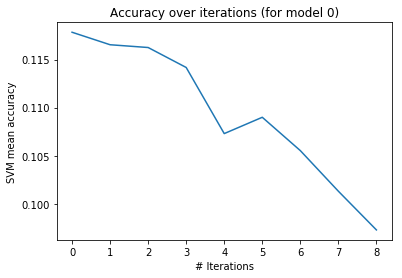

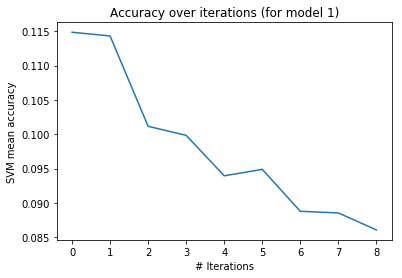

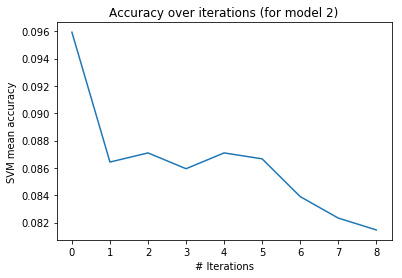

In [21]:
for id_, i in enumerate(mean_acc):
    plt.figure()
    plt.plot(i)
    plt.title('Accuracy over iterations (for model %s)' % id_)
    plt.xlabel('# Iterations')
    plt.ylabel('SVM mean accuracy')
    plt.show()

In [22]:
classes = ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 'skateboard', 
           'train', 'truck']

In [23]:
for i in pred:
    print(classification_report(labels_t, i, target_names = classes))

              precision    recall  f1-score   support

   aeroplane       0.59      0.02      0.03      3646
     bicycle       0.20      0.00      0.00      3475
         bus       0.03      0.00      0.01      4690
         car       0.14      0.04      0.06     10401
       horse       0.08      0.12      0.09      4691
       knife       0.45      0.00      0.00      2075
  motorcycle       0.49      0.13      0.20      5796
      person       0.07      0.00      0.00      4000
       plant       0.18      0.01      0.01      4549
  skateboard       0.00      0.00      0.00      2281
       train       0.08      0.84      0.15      4236
       truck       0.00      0.00      0.00      5548

   micro avg       0.10      0.10      0.10     55388
   macro avg       0.19      0.10      0.05     55388
weighted avg       0.18      0.10      0.06     55388

              precision    recall  f1-score   support

   aeroplane       0.66      0.02      0.04      3646
     bicycle       0.00 

/home/aumkar/anaconda3/envs/daenv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
majority_vote = np.maximum.reduce([pred[0], pred[1], pred[2]])

In [25]:
print(classification_report(labels_t, majority_vote, target_names = classes))

              precision    recall  f1-score   support

   aeroplane       0.62      0.00      0.00      3646
     bicycle       0.00      0.00      0.00      3475
         bus       0.02      0.00      0.00      4690
         car       0.11      0.00      0.00     10401
       horse       0.06      0.00      0.00      4691
       knife       0.00      0.00      0.00      2075
  motorcycle       0.64      0.02      0.03      5796
      person       0.00      0.00      0.00      4000
       plant       0.07      0.03      0.04      4549
  skateboard       0.05      0.01      0.01      2281
       train       0.08      0.99      0.15      4236
       truck       0.02      0.00      0.00      5548

   micro avg       0.08      0.08      0.08     55388
   macro avg       0.14      0.09      0.02     55388
weighted avg       0.15      0.08      0.02     55388

